## Optimisation Algorithm for optimal placement of charging stations in London

Using Gurobi Optimizer, I construct and MILP in the from of a *fixed-charge location problem* to optimise for the locations of charging stations across London. 

In [330]:
from gurobipy import *
import pandas as pd
import numpy as np
from geopy import distance
from tqdm import tnrange, tqdm_notebook

from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline
import matplotlib as mpl

import seaborn as sns
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

Importing data files created in previous notebooks:

In [331]:
demand = pd.read_csv('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/IRR_London_Model/demand_grid_df.csv')
taxi_stands = pd.read_csv('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/IRR_London_Model/london_taxi_ranks_with_geo_coordinates2.csv')

In [332]:
demand.drop(columns = 'Unnamed: 0', inplace=True)
taxi_stands.drop(columns = 'Unnamed: 0', inplace=True)

In [333]:
taxi_stands['stand_number'] = [i for i in range(1, len(taxi_stands)+1)]

In [334]:
taxi_stands.head()

,Borough,Location,Spaces,Times of Operation,Rank No.,Notes,Longitude,Latitude,stand_number
0,Barking and Dagenham,Rainham Road South (Dagenham East Station),1,24 hours,5657.0,NaN,0.165839,51.544181,1
1,Barking and Dagenham,Station Parade/Wakering Road (Barking Station),17,24 hours,5722.0,NaN,0.081832,51.539692,2
2,Barnet,Allum Way (Totteridge and Whetstone Station),2,Friday and Saturday 22:00 – 06:00,5833.0,NaN,-0.179150,51.630235,3
3,Barnet,Barnet General Hospital,3,24 hours,6030.0,Private land,-0.214486,51.650633,4
4,Barnet,Brent Cross Station Car Park (Brent Cross Stat...,2,Friday and Saturday 22:00 – 06:00,5851.0,NaN,-0.213075,51.576688,5


In [335]:
len(taxi_stands)

552

In [336]:
demand.head()

,point,geometry,coords,demand,smoothed_demand,trunc_demand
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,222.506584,222.506584
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,33.057287,33.057287
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,201.586406,201.586406
3,4,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0,-28.495958,0.000000
4,5,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0,-44.836666,0.000000


The energy demand per cell is then calculated by the variables and scalars below:

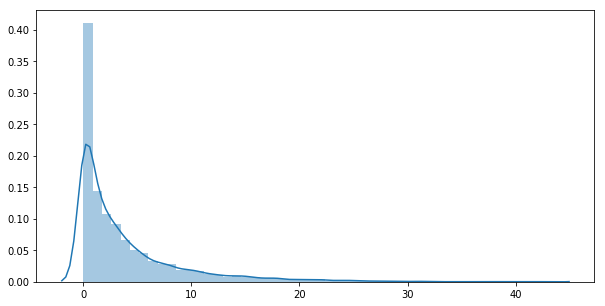

In [337]:
taxi_road_utilisation = 0.17
taxi_consumption_km = 0.1195
taxi_daytime_concentration = 0.74
hours_concentration_factor = 37.2/(14*60)

taxi_demand = np.array(demand.trunc_demand)*taxi_road_utilisation*taxi_consumption_km*taxi_daytime_concentration*hours_concentration_factor
plt.subplots(figsize = (10,5))
sns.distplot(taxi_demand)
plt.show()

demand['taxi_kW_demand'] = taxi_demand

In [338]:
demand.head()

,point,geometry,coords,demand,smoothed_demand,trunc_demand,taxi_kW_demand
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,222.506584,222.506584,0.148134
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,33.057287,33.057287,0.022008
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,201.586406,201.586406,0.134206
3,4,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0,-28.495958,0.000000,0.000000
4,5,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0,-44.836666,0.000000,0.000000


In [339]:
demand.taxi_kW_demand.sum()*0.7/50

338.5632123453646

Need to flip coord tuple to be lat, long for geopy distance function

In [340]:
import re
re.split('[\s+,\[*?\]()]+', list(demand.coords)[0])
split = [re.split('[\s+,\[*?\]()]+', list(demand.coords)[i]) for i in range(len(demand.coords))]
demand_lat_long = []
for i in range(len(split)):
    demand_lat_long.append((float(split[i][2]), float(split[i][1])))

In [341]:
demand['demand_lat_long'] = demand_lat_long

In [342]:
demand.head()                           

,point,geometry,coords,demand,smoothed_demand,trunc_demand,taxi_kW_demand,demand_lat_long
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,222.506584,222.506584,0.148134,"(51.29090909090909, -0.12554744525547445)"
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,33.057287,33.057287,0.022008,"(51.29090909090909, -0.11824817518248176)"
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,201.586406,201.586406,0.134206,"(51.29090909090909, 0.06423357664233575)"
3,4,POINT (-0.1255474452554745 51.29545454545455),"(-0.12554744525547445, 51.29545454545455)",0.0,-28.495958,0.000000,0.000000,"(51.29545454545455, -0.12554744525547445)"
4,5,POINT (-0.1182481751824818 51.29545454545455),"(-0.11824817518248176, 51.29545454545455)",0.0,-44.836666,0.000000,0.000000,"(51.29545454545455, -0.11824817518248176)"


In [343]:
#use only those points for which demand is not 0
demand_filtered = demand.loc[demand.taxi_kW_demand > 0]
demand_filtered.head()

,point,geometry,coords,demand,smoothed_demand,trunc_demand,taxi_kW_demand,demand_lat_long
0,1,POINT (-0.1255474452554745 51.29090909090909),"(-0.12554744525547445, 51.29090909090909)",0.0,222.506584,222.506584,0.148134,"(51.29090909090909, -0.12554744525547445)"
1,2,POINT (-0.1182481751824818 51.29090909090909),"(-0.11824817518248176, 51.29090909090909)",0.0,33.057287,33.057287,0.022008,"(51.29090909090909, -0.11824817518248176)"
2,3,POINT (0.06423357664233575 51.29090909090909),"(0.06423357664233575, 51.29090909090909)",0.0,201.586406,201.586406,0.134206,"(51.29090909090909, 0.06423357664233575)"
7,8,POINT (0.04963503649635037 51.29545454545455),"(0.04963503649635037, 51.29545454545455)",0.0,526.959412,526.959412,0.350824,"(51.29545454545455, 0.04963503649635037)"
8,9,POINT (0.05693430656934306 51.29545454545455),"(0.05693430656934306, 51.29545454545455)",0.0,1258.120905,1258.120905,0.837596,"(51.29545454545455, 0.05693430656934306)"


In [344]:
taxi_stands['candidate_lat_long'] = [(lat, long) for lat, long in zip(taxi_stands.Latitude, taxi_stands.Longitude)]
taxi_stands.head()

,Borough,Location,Spaces,Times of Operation,Rank No.,Notes,Longitude,Latitude,stand_number,candidate_lat_long
0,Barking and Dagenham,Rainham Road South (Dagenham East Station),1,24 hours,5657.0,NaN,0.165839,51.544181,1,"(51.544180700000005, 0.16583879999999998)"
1,Barking and Dagenham,Station Parade/Wakering Road (Barking Station),17,24 hours,5722.0,NaN,0.081832,51.539692,2,"(51.539691999999995, 0.0818324)"
2,Barnet,Allum Way (Totteridge and Whetstone Station),2,Friday and Saturday 22:00 – 06:00,5833.0,NaN,-0.179150,51.630235,3,"(51.6302347, -0.17915029999999998)"
3,Barnet,Barnet General Hospital,3,24 hours,6030.0,Private land,-0.214486,51.650633,4,"(51.650633299999996, -0.21448649999999997)"
4,Barnet,Brent Cross Station Car Park (Brent Cross Stat...,2,Friday and Saturday 22:00 – 06:00,5851.0,NaN,-0.213075,51.576688,5,"(51.5766881, -0.21307529999999997)"


In [345]:
taxi_stands.dtypes

Borough                object
Location               object
Spaces                  int64
Times of Operation     object
Rank No.              float64
Notes                  object
Longitude             float64
Latitude              float64
stand_number            int64
candidate_lat_long     object
dtype: object

### Building a model


#### NO FUNCTION TEST

Function was not working so running as big for loop with reset each time.

In [346]:
demand_test = demand_filtered.set_index('point')

In [347]:
I, h = multidict({node:demand for node,demand in zip(demand_test.index, demand_test.taxi_kW_demand)})

#for now, C = 200 kW i.e. max 4 chargers per candidate location
J = tuplelist(taxi_stands.stand_number)

In [348]:
d = dict()
for i in tqdm_notebook(demand_test.index, desc='Main Loop'):
    for j in taxi_stands.stand_number:
        d[(i,j)] = distance.distance(demand_test.loc[i, 'demand_lat_long'], taxi_stands.loc[j-1, 'candidate_lat_long']).km

In [105]:
max_chargers = list(range(295,746,10))
min_cover = [0.7, 0.8, 0.9, 1]

In [106]:
test_model.reset()

In [107]:
infeasible_mod = dict()
objval, chargers, stations, total_service = dict(), dict(), dict(), dict()

for lower_cover in tqdm_notebook(min_cover, desc='Cover Loop'):
    for max_charger in tqdm_notebook(max_chargers, desc='Charger Iteration'):

        test_model = Model('FCLP_2')

        #VARIABLE ASSIGNMENT
        #init of x_j and num_j
        x = {}
        num = {}
        for j in J:
            x[j] = test_model.addVar(vtype = GRB.BINARY, name = 'x[%s]'%j)
            num[j] = test_model.addVar(vtype = GRB.INTEGER, lb = 0, name = 'num[%s]'%j)

        #Init of y_(i,j)
        y = {}
        for i in I:
            for j in J:
                y[i,j] = test_model.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name="y[%s,%s]"%(i,j))

        #CONSTRAINT ASSIGNMENT
        C = 50 #kW
        MAX_DIST = 12 #km
        MAX_TOTAL = max_charger
        MAX_CHARGERS = 4
        M = 200

        #i) Meeting all demand: sumj_J (y_ij) = 1 forall i
        for i in I:
            test_model.addConstr(sum(y[i,j] for j in J) <= 1, 'Demand_met_up[%s]'%i)
            #test_model.addConstr(sum(y[i,j] for j in J) >= lower_cover, 'Demand_met_low[%s]'%i)
        
        #THIS INSTEAD OF ABOVE
        test_model.addConstr(quicksum(y[i,j] for j in J for i in I) >= lower_cover*len(I))

        #b) demand only assigned to open facilities: y_ij - x_j <= 0 forall i,j
        for i in I:
            for j in J:
                test_model.addConstr(y[i,j] - x[j] <= 0, 'Strong_limit[%i]'%i)

        #c) Max Chargers per candidate location: num_j <= max forall j
        for j in J:
            test_model.addConstr(num[j] <= MAX_CHARGERS*x[j], 'chargers_station[%s]'%j)

        #d) Max total number of chargers: sumj_J (num_j) <= MAX_TOTAL      
        test_model.addConstr(quicksum(num[j] for j in J) <= MAX_TOTAL, 'total_chargers') 

        #e) Max capacity assigned to a station constraint: ∑_(i∈I) h_i . y_ij ≤ C∙num_j-M(1-x_j)
        for j in J:
            test_model.addConstr(quicksum(h[i]*y[i,j] for i in I) <= (C*num[j]), 'Capacity_constraint[%s]'%j)

        #f) distance constraint:
        for i in I:
            for j in J:
                if d[i,j] > MAX_DIST:
                    test_model.addConstr(y[i,j] == 0)

        #SPECIFYING THE OBJECTIVE FUNCTION
        test_model.setObjective(quicksum(h[i]*d[i,j]*y[i,j] for i in I for j in J), GRB.MINIMIZE)

        test_model.reset()
        test_model.setParam('TimeLimit', 6*60)
        test_model.optimize()

        try:
            print('Max_Chargers: {}, ObjVal: {}' .format(max_charger, test_model.ObjVal))
            print('Number of Chargers: {}' .format(sum(num[j].x for j in J)))
            objval[lower_cover, max_charger] = test_model.ObjVal
            chargers[lower_cover, max_charger] = sum(num[j].x for j in J)
            stations[lower_cover, max_charger] = sum(1 for j in J if num[j].x != 0) 
            total_service[lower_cover, max_charger] = sum(y[i,j].x for j in J for i in I)
        except AttributeError:
            print('Model Infeasible')
            infeasible_mod[lower_cover, max_charger] = 'Model Infeasible'

Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 7.74s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 42973.536110

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     41s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     

     0     0 8255.54231    0  110 8338.98291 8255.54231  1.00%     -   41s
     0     0 8256.46810    0   97 8338.98291 8256.46810  0.99%     -   42s
     0     0 8256.70436    0   87 8338.98291 8256.70436  0.99%     -   43s
     0     0 8256.72425    0   86 8338.98291 8256.72425  0.99%     -   44s
     0     0 8260.46329    0   86 8338.98291 8260.46329  0.94%     -   45s
H    0     0                    8295.4823410 8260.46329  0.42%     -   46s
     0     0 8260.61106    0   80 8295.48234 8260.61106  0.42%     -   47s
     0     0 8260.63297    0   81 8295.48234 8260.63297  0.42%     -   48s
     0     0 8260.63614    0   81 8295.48234 8260.63614  0.42%     -   48s
     0     0 8263.29306    0   70 8295.48234 8263.29306  0.39%     -   50s
H    0     0                    8281.0194689 8263.29306  0.21%     -   51s
     0     0 8263.48231    0   65 8281.01947 8263.48231  0.21%     -   52s
     0     0 8263.52189    0   58 8281.01947 8263.52189  0.21%     -   52s
     0     0 8264.55328  

Explored 1 nodes (17058 simplex iterations) in 93.80 seconds
Thread count was 4 (of 4 available processors)

Solution count 10: 8246.93 8247.38 8249.5 ... 8499.52

Optimal solution found (tolerance 1.00e-04)
Best objective 8.246929112670e+03, best bound 8.246152885959e+03, gap 0.0094%
Max_Chargers: 315, ObjVal: 8246.929112670254
Number of Chargers: 315.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 7s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.64s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integ

     0     0 8213.39027    0   56 8246.65685 8213.39027  0.40%     -   48s
H    0     0                    8229.2903166 8213.39027  0.19%     -   50s
     0     0 8213.49116    0   48 8229.29032 8213.49116  0.19%     -   50s
     0     0 8213.49383    0   47 8229.29032 8213.49383  0.19%     -   51s
     0     0 8214.71041    0   50 8229.29032 8214.71041  0.18%     -   52s
     0     0 8214.76214    0   41 8229.29032 8214.76214  0.18%     -   53s
     0     0 8214.76214    0   41 8229.29032 8214.76214  0.18%     -   54s
     0     0 8215.42756    0   31 8229.29032 8215.42756  0.17%     -   55s
H    0     0                    8219.3698353 8215.42756  0.05%     -   56s
     0     0 8215.47054    0   26 8219.36984 8215.47054  0.05%     -   57s
     0     0 8215.47275    0   26 8219.36984 8215.47275  0.05%     -   57s
     0     0 8215.77567    0   13 8219.36984 8215.77567  0.04%     -   59s
H    0     0                    8217.8505868 8215.77567  0.03%     -   60s
     0     0 8215.83779  

Found heuristic solution: objective 33934.564630

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     43s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     43s
       1       1609   1.7304020e+09   3.9709263e+03     44s
       2       5763   9.9407695e+07   5.0002096e+03     44s
       3      11637   8.1999898e+03   7.2903594e+03     44s

Sifting complete

   14812    8.1778929e+03   0.000000e+00   0.000000e+00     44s

Root relaxation: objective 8.177893e+03, 14812 iterations, 0.99 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 8177.89291    0  318 33934.5646 8177.89291  75.9%     -   44s
H    0     0                    13221.459520 8177.89291  3


Cutting planes:
  Gomory: 7
  MIR: 615

Explored 1 nodes (16009 simplex iterations) in 66.37 seconds
Thread count was 4 (of 4 available processors)

Solution count 9: 8189.18 8189.45 8196.09 ... 30092.9

Optimal solution found (tolerance 1.00e-04)
Best objective 8.189182604279e+03, best bound 8.188392739542e+03, gap 0.0096%
Max_Chargers: 365, ObjVal: 8189.182604279075
Number of Chargers: 365.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.16s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Var

Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.18s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 26986.894114

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     31s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     31s
       1       1609   1.7304020e+09   3.9709263e+03     31s
       2       5763   9.9407695e+07   5.0002096e+03     31s
       3      11637   8.1999898e+03   7.2903594e+03     31s

Sifting complete

   

Thread count was 4 (of 4 available processors)

Solution count 2: 8177.89 24735.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.177892908279e+03, best bound 8.177892908279e+03, gap 0.0000%
Max_Chargers: 415, ObjVal: 8177.892908278947
Number of Chargers: 410.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.19s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 23757.037602

Root simplex log

Max_Chargers: 455, ObjVal: 8177.892908278947
Number of Chargers: 410.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.20s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 20766.402367

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     34s

Starting sifting (using dual simplex for sub-problems)...

    Iter     

   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.27s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 18964.236182

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     13s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1  

Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.71s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 17518.357009

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     14s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     14s
       1       1609   1.7304020e+09   3.9709263e+03     14s
       2       5763   9.9407695e+07   5.0002096e+03     14s
       3      11637   8.1999898e+03   7.2903594e+03     14s

Sifting complete

   

  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.23s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1609   1.7304020e+09   3.9709263e+03     13s
       2       5763   9.9407695e+07   5.0002096e+03     13s
       3      11637   8.1999898e+03   7.2903594e+03     13s

Sifting complete

   14812    8.1778929e+03   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 8.177893e+03, 14812 iterations, 0.92 seconds

    Nodes    |    Current Node    |     

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.31s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     13s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1609   1.7304020e+09   3.9709263e+03     13s
       2       5763   9.9407695e+07   5.0002096e+03     13s
       3      11637   8.1999898e+03   7.2903594e+03     13s

Sifting complete

   14812    8.1778929e+03   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 8.177893e+03, 14812 iterations, 0.92 seconds

    No

  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.38s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     13s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1609   1.7304020e+09   3.9709263e+03     13s
       2       5763   9.9407695e+07   5.0002096e+03     13s
       3      11637   8.1999898e+03   7.2903594e+03     13s

Sifting complete

   14812    8.1778929e+03   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 8.177893e+03, 1481

  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.21s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     12s
       1       1609   1.7304020e+09   3.9709263e+03     13s
       2       5763   9.9407695e+07   5.0002096e+03     13s
       3      11637   8.1999898e+03   7.2903594e+03     13s

Sifting complete

   14812    8.1778929e+03   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 8.177893e+03, 14812 iterations, 0.92 seconds

    Nodes    |    Current Node    |     

Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.13s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     12s
       1       1609   1.7304020e+09   3.9709263e+03     13s
       2       5763   9.9407695e+07   5.0002096e+03     13s
       3      11637   8.1999898e+03   7.2903594e+03     13s

Sifting complete

   14812    8.1778929e+03   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 8.177893e+03, 14812 iterations, 0.91 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.16s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 80683.372543

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.097600e+03   0.000000e+00     34s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     


Solution count 10: 12426.1 12429.2 12432.8 ... 12610.3

Time limit reached
Best objective 1.242608620557e+04, best bound 1.240779267454e+04, gap 0.1472%
Max_Chargers: 295, ObjVal: 12426.086205568674
Number of Chargers: 295.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.16s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 78636.006096

Root simplex log...

Iteration    Objective       Primal Inf.    Du

Thread count was 4 (of 4 available processors)

Solution count 10: 12360 12360.7 12364 ... 13382.7

Time limit reached
Best objective 1.236002979894e+04, best bound 1.234303751340e+04, gap 0.1375%
Max_Chargers: 305, ObjVal: 12360.029798944815
Number of Chargers: 305.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 7.00s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 78363.492708

Root simplex log...

Ite


Cutting planes:
  Gomory: 52
  MIR: 1285

Explored 753 nodes (60698 simplex iterations) in 360.93 seconds
Thread count was 4 (of 4 available processors)

Solution count 10: 12298.8 12299.6 12299.7 ... 12391.9

Time limit reached
Best objective 1.229878724567e+04, best bound 1.228741788503e+04, gap 0.0924%
Max_Chargers: 315, ObjVal: 12298.787245666606
Number of Chargers: 315.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.97s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 82721


Solution count 10: 12247.4 12247.5 12250.9 ... 12354.2

Time limit reached
Best objective 1.224738817491e+04, best bound 1.223944332609e+04, gap 0.0649%
Max_Chargers: 325, ObjVal: 12247.38817490589
Number of Chargers: 325.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 7.06s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 62073.873500

Root simplex log...

Iteration    Objective       Primal Inf.    Dua

   786   629 12204.6903   76   57 12205.3568 12197.3561  0.07%   8.6  358s

Cutting planes:
  Gomory: 42
  MIR: 1178

Explored 787 nodes (57471 simplex iterations) in 360.48 seconds
Thread count was 4 (of 4 available processors)

Solution count 10: 12205.4 12205.8 12209.8 ... 12358.6

Time limit reached
Best objective 1.220535683175e+04, best bound 1.219764110539e+04, gap 0.0632%
Max_Chargers: 335, ObjVal: 12205.356831747757
Number of Chargers: 335.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.18s
P

Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.14s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 59821.107612

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.097600e+03   0.000000e+00     30s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     

Thread count was 4 (of 4 available processors)

Solution count 10: 12135.4 12136 12137 ... 12201.1

Time limit reached
Best objective 1.213544732113e+04, best bound 1.213236902985e+04, gap 0.0254%
Max_Chargers: 355, ObjVal: 12135.44732113387
Number of Chargers: 355.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.10s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 52031.792551

Root simplex log...

Iter

   784   439 12108.3990  133   31 12108.5325 12106.0906  0.02%   8.8  327s
   785   440 12106.8271   15   26 12108.5325 12106.1934  0.02%   8.8  339s
   786   441 12107.4253   28   26 12108.5325 12106.2224  0.02%   8.7  340s
   790   443 12108.2589  122   24 12108.5325 12106.2485  0.02%   8.7  345s
   791   444 12107.1472   34   34 12108.5325 12106.3541  0.02%   8.7  357s

Cutting planes:
  Gomory: 31
  Implied bound: 2
  MIR: 936

Explored 793 nodes (59270 simplex iterations) in 360.48 seconds
Thread count was 4 (of 4 available processors)

Solution count 10: 12108.5 12108.8 12109.7 ... 12127.1

Time limit reached
Best objective 1.210853251275e+04, best bound 1.210645899218e+04, gap 0.0171%
Max_Chargers: 365, ObjVal: 12108.532512745558
Number of Chargers: 365.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (5

       0          0     infinity      0.0000000e+00     30s
       1       1608   2.2426020e+09   4.8946387e+03     30s
       2       5757   6.1160769e+08   6.8471772e+03     30s
       3      12376   1.2419938e+04   8.5633844e+03     31s
       4      16839   1.2051624e+04   1.0994281e+04     31s

Sifting complete

   20839    1.2020288e+04   0.000000e+00   0.000000e+00     31s

Root relaxation: objective 1.202029e+04, 20839 iterations, 1.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12020.2877    0  337 46971.2746 12020.2877  74.4%     -   31s
H    0     0                    13174.058682 12020.2877  8.76%     -   33s
     0     0 12037.2968    0  179 13174.0587 12037.2968  8.63%     -   35s
H    0     0                    12294.067839 12037.2968  2.09%     -   37s
     0     0 12054.2088    0  135 12294.0678 12054.2088  1.95%     -   39s
H    0     0     

     0     0 12054.4090    0   52 12064.8466 12054.4090  0.09%     -   55s
     0     0 12054.7774    0   42 12064.8466 12054.7774  0.08%     -   56s
     0     0 12054.7893    0   42 12064.8466 12054.7893  0.08%     -   57s
     0     0 12054.8034    0   42 12064.8466 12054.8034  0.08%     -   58s
     0     0 12055.0270    0   47 12064.8466 12055.0270  0.08%     -   60s
     0     0 12055.0322    0   46 12064.8466 12055.0322  0.08%     -   61s
     0     0 12055.1141    0   40 12064.8466 12055.1141  0.08%     -   62s
H    0     0                    12058.536433 12055.1141  0.03%     -   64s
     0     0 12055.1532    0   37 12058.5364 12055.1532  0.03%     -   64s
     0     0 12055.1609    0   37 12058.5364 12055.1609  0.03%     -   65s
     0     0 12055.2552    0   28 12058.5364 12055.2552  0.03%     -   67s
     0     0 12055.2698    0   32 12058.5364 12055.2698  0.03%     -   69s
     0     0 12055.2713    0   32 12058.5364 12055.2713  0.03%     -   70s
     0     0 12055.3136  

       0    0.0000000e+00   4.097600e+03   0.000000e+00     35s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     35s
       1       1608   2.2426020e+09   4.8946387e+03     35s
       2       5757   6.1160769e+08   6.8471772e+03     35s
       3      12376   1.2419938e+04   8.5633844e+03     35s
       4      16839   1.2051624e+04   1.0994281e+04     35s

Sifting complete

   20839    1.2020288e+04   0.000000e+00   0.000000e+00     36s

Root relaxation: objective 1.202029e+04, 20839 iterations, 1.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12020.2877    0  330 42279.2047 12020.2877  71.6%     -   36s
H    0     0                    24764.628464 12020.2877  51.5%     -   37s
H    0     0                    13129.358798 12020.2877  8

Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.12s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 40084.925157

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.097600e+03   0.000000e+00     30s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     31s
       1       1608   2.2426020e+09   4.8946387e+03     31s
       2       5757   6.1160769e+08   6.8471772e+03     31s
       3      12376 

       1       1608   2.2426020e+09   4.8946387e+03     36s
       2       5757   6.1160769e+08   6.8471772e+03     36s
       3      12376   1.2419938e+04   8.5633844e+03     36s
       4      16839   1.2051624e+04   1.0994281e+04     37s

Sifting complete

   20839    1.2020288e+04   0.000000e+00   0.000000e+00     37s

Root relaxation: objective 1.202029e+04, 20839 iterations, 1.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12020.2877    0  318 35489.0899 12020.2877  66.1%     -   37s
H    0     0                    18383.374357 12020.2877  34.6%     -   38s
H    0     0                    13090.566544 12020.2877  8.18%     -   39s
     0     0 12020.2877    0   63 13090.5665 12020.2877  8.18%     -   40s
H    0     0                    12124.177367 12020.2877  0.86%     -   42s
     0     0 12020.9580    0   51 12124.1774 12020.9580  0.85%     -   45s
H 

Max_Chargers: 475, ObjVal: 12020.863382884854
Number of Chargers: 475.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.11s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 32626.922535

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.097600e+03   0.000000e+00     31s

Starting sifting (using dual simplex for sub-problems)...

    Iter    


Optimal solution found (tolerance 1.00e-04)
Best objective 1.202028773316e+04, best bound 1.202028773316e+04, gap 0.0000%
Max_Chargers: 515, ObjVal: 12020.287733162526
Number of Chargers: 484.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.12s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 29232.747687

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0

Thread count was 4 (of 4 available processors)

Solution count 2: 12020.3 28389.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.202028773316e+04, best bound 1.202028773316e+04, gap 0.0000%
Max_Chargers: 555, ObjVal: 12020.287733162526
Number of Chargers: 484.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.18s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 28195.758274

Root simplex lo


     0     0 12020.2877    0  272          - 12020.2877      -     -   13s
H    0     0                    28970.308807 12020.2877  58.5%     -   14s
H    0     0                    25694.542358 12020.2877  53.2%     -   16s
H    0     0                    12020.287733 12020.2877  0.00%     -   16s

Explored 1 nodes (20851 simplex iterations) in 16.84 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 12020.3 25694.5 28970.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.202028773316e+04, best bound 1.202028773316e+04, gap 0.0000%
Max_Chargers: 595, ObjVal: 12020.287733162526
Number of Chargers: 484.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1

       2       5757   6.1160769e+08   6.8471772e+03     13s
       3      12376   1.2419938e+04   8.5633844e+03     13s
       4      16839   1.2051624e+04   1.0994281e+04     13s

Sifting complete

   20839    1.2020288e+04   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 1.202029e+04, 20839 iterations, 1.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12020.2877    0  259          - 12020.2877      -     -   13s
H    0     0                    26291.197301 12020.2877  54.3%     -   14s
H    0     0                    23847.138402 12020.2877  49.6%     -   16s
H    0     0                    12020.287733 12020.2877  0.00%     -   16s

Explored 1 nodes (20851 simplex iterations) in 16.85 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 12020.3 23847.1 26291.2 

Optimal solution found (tolerance 1.00e-04)
Best objective

Presolve time: 6.10s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.097600e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     12s
       1       1608   2.2426020e+09   4.8946387e+03     13s
       2       5757   6.1160769e+08   6.8471772e+03     13s
       3      12376   1.2419938e+04   8.5633844e+03     13s
       4      16839   1.2051624e+04   1.0994281e+04     13s

Sifting complete

   20839    1.2020288e+04   0.000000e+00   0.000000e+00     13s

Root relaxation: objective 1.202029e+04, 20839 iterations, 1.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.08s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.097600e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     12s
       1       1608   2.2426020e+09   4.8946387e+03     13s
       2       5757   6.1160769e+08   6.8471772e+03     13s
       3      12376   1.2419938e+04   8.5633844e+03     13s
       4 


Explored 1 nodes (20851 simplex iterations) in 15.92 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 12020.3 20389.8 21290 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.202028773316e+04, best bound 1.202028773316e+04, gap 0.0000%
Max_Chargers: 745, ObjVal: 12020.287733162526
Number of Chargers: 620.0


Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.08s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.609800e+03   0.000000e+00     43s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     43s
       1     

     0     0 21313.0587    0  185          - 21313.0587      -     -  144s
     0     0 21313.2062    0  184          - 21313.2062      -     -  145s
     0     0 21314.6468    0  191          - 21314.6468      -     -  147s
     0     0 21314.6468    0  191          - 21314.6468      -     -  177s
H    0     0                    21807.525034 21314.6468  2.26%     -  180s
     0     2 21314.6468    0  190 21807.5250 21314.6468  2.26%     -  192s
     3     6 21318.4297    2  183 21807.5250 21316.7927  2.25%   185  196s
    13    13 21320.1674    7  182 21807.5250 21316.7927  2.25%   111  201s
    27    28 21323.0737   12  182 21807.5250 21316.7927  2.25%  68.5  207s
    44    46 21328.4552   20  174 21807.5250 21316.7927  2.25%  59.8  210s
    56    57 21333.9104   27  169 21807.5250 21316.7927  2.25%  54.7  217s
    63    66 21338.8887   29  168 21807.5250 21316.7927  2.25%  53.1  220s
    78    79 21336.1334   35  177 21807.5250 21316.7927  2.25%  47.0  225s
    98   100 21341.1635  

     0     0 20087.3613    0  212          - 20087.3613      -     -  132s
     0     0 20087.8493    0  210          - 20087.8493      -     -  135s
     0     0 20087.9755    0  213          - 20087.9755      -     -  136s
     0     0 20089.6988    0  197          - 20089.6988      -     -  139s
     0     0 20090.0447    0  202          - 20090.0447      -     -  141s
     0     0 20090.2323    0  200          - 20090.2323      -     -  142s
     0     0 20091.5449    0  205          - 20091.5449      -     -  144s
     0     0 20091.5449    0  204          - 20091.5449      -     -  182s
H    0     0                    21106.212355 20091.5449  4.81%     -  186s
     0     2 20091.5449    0  203 21106.2124 20091.5449  4.81%     -  199s
     1     4 20096.6219    1  202 21106.2124 20091.5558  4.81%  70.0  201s
     3     6 20098.0773    2  198 21106.2124 20092.3506  4.80%   128  207s
    11    12 20100.6481    6  198 21106.2124 20093.8770  4.80%  90.9  210s
    27    30 20104.8782  

     0     0 19454.2872    0  226          - 19454.2872      -     -  124s
     0     0 19454.9642    0  209          - 19454.9642      -     -  126s
     0     0 19455.2738    0  211          - 19455.2738      -     -  127s
     0     0 19455.4505    0  210          - 19455.4505      -     -  128s
     0     0 19457.7923    0  208          - 19457.7923      -     -  130s
     0     0 19458.4123    0  211          - 19458.4123      -     -  132s
     0     0 19458.6455    0  210          - 19458.6455      -     -  133s
     0     0 19458.7162    0  217          - 19458.7162      -     -  134s
     0     0 19460.7192    0  203          - 19460.7192      -     -  136s
     0     0 19461.3368    0  205          - 19461.3368      -     -  138s
     0     0 19461.5166    0  202          - 19461.5166      -     -  139s
     0     0 19462.6647    0  215          - 19462.6647      -     -  141s
     0     0 19462.6647    0  215          - 19462.6647      -     -  165s
H    0     0             

     0     0 19023.6353    0  211          - 19023.6353      -     -  142s
     0     0 19023.7781    0  214          - 19023.7781      -     -  143s
     0     0 19026.5543    0  214          - 19026.5543      -     -  145s
     0     0 19027.3143    0  220          - 19027.3143      -     -  147s
     0     0 19027.5582    0  227          - 19027.5582      -     -  148s
     0     0 19027.6525    0  226          - 19027.6525      -     -  149s
     0     0 19029.2447    0  223          - 19029.2447      -     -  151s
     0     0 19029.7744    0  221          - 19029.7744      -     -  153s
     0     0 19030.0008    0  218          - 19030.0008      -     -  155s
     0     0 19032.0348    0  220          - 19032.0348      -     -  157s
     0     0 19032.3916    0  225          - 19032.3916      -     -  159s
     0     0 19032.4865    0  236          - 19032.4865      -     -  160s
     0     0 19033.6709    0  231          - 19033.6709      -     -  162s
     0     0 19033.6709  

     0     0 18744.2440    0  237          - 18744.2440      -     -  143s
     0     0 18744.3448    0  241          - 18744.3448      -     -  144s
     0     0 18747.1108    0  236          - 18747.1108      -     -  146s
     0     0 18747.5365    0  236          - 18747.5365      -     -  148s
     0     0 18747.6207    0  232          - 18747.6207      -     -  149s
     0     0 18749.6368    0  237          - 18749.6368      -     -  152s
     0     0 18749.8960    0  229          - 18749.8960      -     -  154s
     0     0 18750.0051    0  234          - 18750.0051      -     -  155s
     0     0 18751.6244    0  234          - 18751.6244      -     -  158s
     0     0 18751.6244    0  232          - 18751.6244      -     -  195s
H    0     0                    19012.074225 18751.6244  1.37%     -  198s
     0     2 18751.6244    0  232 19012.0742 18751.6244  1.37%     -  206s
     3     6 18791.3288    2  238 19012.0742 18751.7749  1.37%   107  211s
    18    19 18800.0014  

     0     0 18560.4949    0  239          - 18560.4949      -     -  130s
     0     0 18561.1576    0  242          - 18561.1576      -     -  132s
     0     0 18561.2993    0  233          - 18561.2993      -     -  133s
     0     0 18563.2750    0  239          - 18563.2750      -     -  135s
     0     0 18563.9005    0  241          - 18563.9005      -     -  137s
     0     0 18563.9539    0  241          - 18563.9539      -     -  138s
     0     0 18565.1013    0  254          - 18565.1013      -     -  141s
     0     0 18565.1013    0  250          - 18565.1013      -     -  183s
H    0     0                    18796.731590 18565.1013  1.23%     -  186s
     0     2 18565.1013    0  250 18796.7316 18565.1013  1.23%     -  194s
     1     4 18597.1662    1  248 18796.7316 18565.1084  1.23%  83.0  196s
     3     6 18602.5341    2  254 18796.7316 18565.2966  1.23%  82.3  200s
    11    12 18604.9725    6  253 18796.7316 18566.9105  1.22%  80.5  205s
    25    24 18608.2619  

H    0     0                    18735.038463 18444.8329  1.55%     -   92s
     0     0 18445.3298    0  211 18735.0385 18445.3298  1.55%     -   92s
     0     0 18445.6015    0  211 18735.0385 18445.6015  1.54%     -   93s
     0     0 18445.6484    0  204 18735.0385 18445.6484  1.54%     -   94s
     0     0 18447.9533    0  223 18735.0385 18447.9533  1.53%     -   96s
H    0     0                    18587.461064 18447.9533  0.75%     -   99s
     0     0 18448.1802    0  213 18587.4611 18448.1802  0.75%     -  100s
     0     0 18448.2549    0  224 18587.4611 18448.2549  0.75%     -  100s
     0     0 18449.4259    0  215 18587.4611 18449.4259  0.74%     -  103s
     0     0 18449.4259    0  213 18587.4611 18449.4259  0.74%     -  151s
     0     2 18449.4259    0  213 18587.4611 18449.4259  0.74%     -  156s
     3     6 18450.9957    2  207 18587.4611 18450.9957  0.73%  77.3  164s
     9    10 18451.6409    5  205 18587.4611 18451.6409  0.73%  48.9  168s
    13    14 18452.2439  

     0     0 18353.8141    0  216 18606.2705 18353.8141  1.36%     -   84s
     0     0 18354.8344    0  214 18606.2705 18354.8344  1.35%     -   85s
     0     0 18354.9367    0  211 18606.2705 18354.9367  1.35%     -   86s
     0     0 18358.7417    0  215 18606.2705 18358.7417  1.33%     -   88s
H    0     0                    18528.495238 18358.7417  0.92%     -   90s
     0     0 18359.3378    0  217 18528.4952 18359.3378  0.91%     -   90s
     0     0 18359.5133    0  219 18528.4952 18359.5133  0.91%     -   91s
     0     0 18359.5656    0  223 18528.4952 18359.5656  0.91%     -   91s
     0     0 18361.5555    0  210 18528.4952 18361.5555  0.90%     -   93s
H    0     0                    18487.645706 18361.5555  0.68%     -   96s
     0     0 18361.8474    0  214 18487.6457 18361.8474  0.68%     -   96s
     0     0 18361.8895    0  206 18487.6457 18361.8895  0.68%     -   97s
     0     0 18363.1084    0  204 18487.6457 18363.1084  0.67%     -   99s
H    0     0             

     0     0 18276.5051    0  223 18469.6389 18276.5051  1.05%     -   72s
     0     0 18276.5167    0  224 18469.6389 18276.5167  1.05%     -   73s
     0     0 18282.7938    0  199 18469.6389 18282.7938  1.01%     -   74s
     0     0 18283.3176    0  196 18469.6389 18283.3176  1.01%     -   77s
     0     0 18283.4129    0  199 18469.6389 18283.4129  1.01%     -   78s
     0     0 18287.5456    0  186 18469.6389 18287.5456  0.99%     -   80s
H    0     0                    18440.130740 18287.5456  0.83%     -   82s
     0     0 18288.0317    0  192 18440.1307 18288.0317  0.82%     -   83s
     0     0 18288.1168    0  194 18440.1307 18288.1168  0.82%     -   84s
     0     0 18291.6075    0  203 18440.1307 18291.6075  0.81%     -   86s
H    0     0                    18439.939116 18291.6075  0.80%     -   89s
     0     0 18291.8431    0  191 18439.9391 18291.8431  0.80%     -   90s
     0     0 18291.8903    0  189 18439.9391 18291.8903  0.80%     -   90s
     0     0 18293.7351  

     0     0 18194.4676    0  207 18540.6367 18194.4676  1.87%     -   57s
     0     0 18194.4897    0  212 18540.6367 18194.4897  1.87%     -   58s
     0     0 18208.5971    0  215 18540.6367 18208.5971  1.79%     -   60s
H    0     0                    18412.006367 18208.5971  1.10%     -   62s
     0     0 18211.4886    0  216 18412.0064 18211.4886  1.09%     -   62s
     0     0 18212.1027    0  204 18412.0064 18212.1027  1.09%     -   63s
     0     0 18212.1826    0  205 18412.0064 18212.1826  1.09%     -   64s
     0     0 18212.1941    0  202 18412.0064 18212.1941  1.09%     -   64s
     0     0 18219.9919    0  200 18412.0064 18219.9919  1.04%     -   66s
     0     0 18221.0971    0  203 18412.0064 18221.0971  1.04%     -   69s
     0     0 18221.2520    0  203 18412.0064 18221.2520  1.04%     -   69s
     0     0 18221.3463    0  207 18412.0064 18221.3463  1.04%     -   70s
     0     0 18221.3475    0  206 18412.0064 18221.3475  1.04%     -   71s
     0     0 18225.3531  


     0     0 17960.8795    0  350 79221.9075 17960.8795  77.3%     -   38s
H    0     0                    19466.269076 17960.8795  7.73%     -   43s
     0     0 18056.8666    0  278 19466.2691 18056.8666  7.24%     -   45s
H    0     0                    18443.340020 18056.8666  2.10%     -   47s
     0     0 18114.8216    0  238 18443.3400 18114.8216  1.78%     -   49s
     0     0 18124.6925    0  225 18443.3400 18124.6925  1.73%     -   50s
     0     0 18126.1487    0  223 18443.3400 18126.1487  1.72%     -   50s
     0     0 18126.1603    0  223 18443.3400 18126.1603  1.72%     -   51s
     0     0 18150.5112    0  207 18443.3400 18150.5112  1.59%     -   53s
H    0     0                    18415.984753 18150.5112  1.44%     -   54s
     0     0 18153.3546    0  202 18415.9848 18153.3546  1.43%     -   55s
     0     0 18154.1092    0  196 18415.9848 18154.1092  1.42%     -   55s
     0     0 18154.2166    0  193 18415.9848 18154.2166  1.42%     -   56s
     0     0 18154.2305 

       6      34687   1.8081344e+04   1.1292513e+04     37s
       7      39356   1.8022624e+04   1.3180446e+04     38s
       8      44029   1.7983365e+04   1.4522544e+04     38s
       9      48781   1.7975425e+04   1.5508493e+04     38s
      10      53446   1.7964231e+04   1.6468139e+04     38s
      11      58130   1.7961008e+04   1.7013419e+04     38s
      12      62847   1.7960880e+04   1.7523807e+04     38s

Sifting complete

   67531    1.7960880e+04   0.000000e+00   0.000000e+00     38s

Root relaxation: objective 1.796088e+04, 67531 iterations, 2.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17960.8795    0  347 77745.4846 17960.8795  76.9%     -   39s
H    0     0                    19487.933224 17960.8795  7.84%     -   44s
     0     0 18037.3628    0  261 19487.9332 18037.3628  7.44%     -   46s
H    0     0                    18354.968256 18

       0    0.0000000e+00   4.609800e+03   0.000000e+00     39s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     39s
       1       1606   2.7548020e+09   5.8183511e+03     39s
       2       5749   1.1238077e+09   8.6941447e+03     39s
       3      12768   3.0281523e+08   9.4177083e+03     39s
       4      21187   1.4681809e+08   9.5830983e+03     40s
       5      29876   1.8259804e+04   1.0132550e+04     40s
       6      34687   1.8081344e+04   1.1292513e+04     40s
       7      39356   1.8022624e+04   1.3180446e+04     40s
       8      44029   1.7983365e+04   1.4522544e+04     40s
       9      48781   1.7975425e+04   1.5508493e+04     40s
      10      53446   1.7964231e+04   1.6468139e+04     40s
      11      58130   1.7961008e+04   1.7013419e+04     40s
      12      62847   1.7960880e+04   1.7523807e+04     41s

Sifting complete

   67531    1.796

Max_Chargers: 425, ObjVal: 18130.993830483265
Number of Chargers: 425.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.07s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 73707.049786

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.609800e+03   0.000000e+00     40s

Starting sifting (using dual simplex for sub-problems)...

    Iter    

   779   617 18093.7057  155   64 18095.1184 18085.1558  0.06%   6.3  354s
   781   619 18093.1465   69   65 18095.1184 18085.2228  0.05%   6.3  355s

Cutting planes:
  Gomory: 87
  MIR: 1162

Explored 783 nodes (153542 simplex iterations) in 360.65 seconds
Thread count was 4 (of 4 available processors)

Solution count 10: 18095.1 18095.5 18096.9 ... 18171.1

Time limit reached
Best objective 1.809511843243e+04, best bound 1.808530453152e+04, gap 0.0542%
Max_Chargers: 435, ObjVal: 18095.11843242626
Number of Chargers: 435.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) .

   768   599 18062.5380   42   73 18064.7702 18056.4432  0.05%   6.9  240s
   776   604 18061.7536   52   63 18064.7702 18056.4432  0.05%   6.8  246s
   777   605 18064.2895   54   55 18064.7702 18056.8306  0.04%   6.8  262s
   779   606 18061.8783   53   57 18064.7702 18056.8716  0.04%   6.8  265s
   780   607 18063.4625   69   64 18064.7702 18057.3186  0.04%   6.8  278s
   782   608 18061.2862   37   62 18064.7702 18057.8419  0.04%   6.7  280s
   786   611 18059.6384   14   52 18064.7702 18058.0566  0.04%   6.7  296s
   791   614 18062.5619   50   56 18064.7702 18058.3665  0.04%   6.7  301s
   792   615 18060.8532   23   58 18064.7702 18058.4681  0.03%   6.6  315s
   795   617 18062.2919   18   54 18064.7702 18058.5159  0.03%   6.6  329s
   796   617 18061.3569   26   54 18064.7702 18058.5453  0.03%   6.6  330s
   800   620 18058.6731   21   64 18064.7702 18058.6731  0.03%   6.6  345s

Cutting planes:
  Gomory: 72
  MIR: 1070

Explored 804 nodes (153693 simplex iterations) in 360.43 

   733   559 18039.9111  131  332 18042.1461 18032.9530  0.05%   6.3  227s
   734   560 18040.4301  153  194 18042.1461 18032.9530  0.05%   6.3  231s
   739   563 18041.7632  199   64 18042.1461 18032.9530  0.05%   6.3  235s
   746   568 18038.8059   67   52 18042.1461 18033.0754  0.05%   6.2  252s
   749   570 18039.5231  100   50 18042.1461 18033.2425  0.05%   6.2  255s
   750   571 18038.6536   86   49 18042.1461 18033.7236  0.05%   6.2  267s
   753   573 18036.1194   30   56 18042.1461 18034.0344  0.04%   6.2  270s
   756   575 18038.4246   67   69 18042.1461 18034.5136  0.04%   6.1  285s
   761   578 18038.9631   72   66 18042.1461 18034.7651  0.04%   6.1  290s
   762   579 18040.6034  118   57 18042.1461 18034.9415  0.04%   6.1  300s
   766   581 18040.9998  139   46 18042.1461 18035.1515  0.04%   6.0  317s
   769   583 18041.4742  151   49 18042.1461 18035.3352  0.04%   6.0  320s
   772   585 18040.4882  104   48 18042.1461 18035.4290  0.04%   6.0  334s
   773   586 18039.4774  

   333   199 18018.1732   34   29 18020.2018 18015.1899  0.03%   5.7  149s
H  371   225                    18020.121362 18015.1899  0.03%   5.6  149s
   393   231 18019.4332   71    5 18020.1214 18015.1899  0.03%   5.5  155s
   459   253 18020.0860   98    4 18020.1214 18015.2621  0.03%   5.8  161s
   535   322 18017.8027   32   35 18020.1214 18015.3764  0.03%   5.9  166s
H  611   374                    18020.107523 18015.3764  0.03%   6.2  171s
   687   443 18019.2557   91    4 18020.1075 18015.3764  0.03%   6.2  178s
   763   498 18019.1317   41   49 18020.1075 18015.3764  0.03%   6.2  208s
   765   499 18018.9908   39  322 18020.1075 18015.3764  0.03%   6.2  214s
   766   500 18018.2581   33  169 18020.1075 18015.3764  0.03%   6.2  227s
   770   503 18020.0712   45   72 18020.1075 18015.3764  0.03%   6.2  230s
   779   509 18019.6166   48   50 18020.1075 18015.3764  0.03%   6.1  236s
   780   509 18017.9791   18   47 18020.1075 18015.3764  0.03%   6.1  249s
   781   510 18017.5259  

   276   207 18003.9278  128   16 18004.1590 17999.7255  0.02%   5.1  131s
   333   233 18000.1497    7   33 18004.1590 17999.7366  0.02%   5.6  136s
   390   278 18002.5732   43   31 18004.1590 17999.7366  0.02%   6.2  142s
H  428   282                    18003.941924 17999.7366  0.02%   6.1  142s
   449   292 18003.5756   78   24 18003.9419 17999.9808  0.02%   6.0  149s
   525   323 18001.1299   12   27 18003.9419 17999.9808  0.02%   5.8  154s
   601   386 18003.0516   49   28 18003.9419 17999.9808  0.02%   5.9  160s
   677   436 18003.7283   87   22 18003.9419 17999.9808  0.02%   5.8  165s
   754   487 18001.9552   15   32 18003.9419 17999.9808  0.02%   5.7  193s
   756   488 18003.8547  207  312 18003.9419 17999.9808  0.02%   5.6  206s
   757   489 18000.1891    2  159 18003.9419 17999.9808  0.02%   5.6  211s
   763   493 18002.9993   65   53 18003.9419 17999.9808  0.02%   5.6  215s
   769   497 18002.6664   43   37 18003.9419 17999.9808  0.02%   5.6  231s
   772   499 18000.2174  

*  465   245             116    17990.793689 17988.7629  0.01%   6.9  145s
   518   267 17989.3679   18   19 17990.7937 17988.7800  0.01%   7.1  151s
   594   314 17990.3580   49   13 17990.7937 17988.7800  0.01%   6.8  157s
   667   367 17990.6951   80    5 17990.7937 17988.7800  0.01%   6.9  162s
   744   415 17990.4953   19   24 17990.7937 17988.7882  0.01%   6.7  195s
   746   416 17989.2197   17  284 17990.7937 17988.7882  0.01%   6.7  211s
   747   417 17989.7190   17  129 17990.7937 17988.7882  0.01%   6.7  215s
   754   422 17990.3948   52   28 17990.7937 17988.7882  0.01%   6.6  220s
   758   424 17989.7781   22   22 17990.7937 17988.7882  0.01%   6.6  235s
   760   426 17990.5292   24   19 17990.7937 17988.7882  0.01%   6.6  247s
   762   427 17990.2049   44   20 17990.7937 17988.7882  0.01%   6.5  250s
   763   428 17990.1806   74   18 17990.7937 17988.7882  0.01%   6.5  264s
   764   428 17990.7816   25   19 17990.7937 17988.7882  0.01%   6.5  265s
   765   429 17990.6340  

       0    0.0000000e+00   4.609800e+03   0.000000e+00     15s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     15s
       1       1606   2.7548020e+09   5.8183511e+03     15s
       2       5749   1.1238077e+09   8.6941447e+03     15s
       3      12768   3.0281523e+08   9.4177083e+03     15s
       4      21187   1.4681809e+08   9.5830983e+03     16s
       5      29876   1.8259804e+04   1.0132550e+04     16s
       6      34687   1.8081344e+04   1.1292513e+04     16s
       7      39356   1.8022624e+04   1.3180446e+04     16s
       8      44029   1.7983365e+04   1.4522544e+04     16s
       9      48781   1.7975425e+04   1.5508493e+04     16s
      10      53446   1.7964231e+04   1.6468139e+04     16s
      11      58130   1.7961008e+04   1.7013419e+04     16s
      12      62847   1.7960880e+04   1.7523807e+04     17s

Sifting complete

   67531    1.796

     0     0 17967.6033    0   24 17979.6204 17967.6033  0.07%     -   35s
     0     0 17967.6103    0   21 17979.6204 17967.6103  0.07%     -   36s
     0     0 17967.6105    0   21 17979.6204 17967.6105  0.07%     -   37s
     0     0 17967.6663    0   18 17979.6204 17967.6663  0.07%     -   38s
     0     0 17967.6808    0   19 17979.6204 17967.6808  0.07%     -   39s
     0     0 17967.6808    0   18 17979.6204 17967.6808  0.07%     -   39s
     0     0 17967.6984    0   11 17979.6204 17967.6984  0.07%     -   41s
H    0     0                    17975.370153 17967.6984  0.04%     -   41s
H    0     0                    17970.053264 17967.6984  0.01%     -   62s
     0     0 17967.6993    0   12 17970.0533 17967.6993  0.01%     -   62s
     0     0 17967.7074    0    9 17970.0533 17967.7074  0.01%     -   63s
H    0     0                    17969.498282 17967.7074  0.01%     -   65s

Cutting planes:
  Gomory: 4
  MIR: 549

Explored 1 nodes (68547 simplex iterations) in 65.46 second

     0     0 17962.4952    0   38 17974.2526 17962.4952  0.07%     -   30s
     0     0 17962.6996    0   30 17974.2526 17962.6996  0.06%     -   31s
     0     0 17962.7161    0   29 17974.2526 17962.7161  0.06%     -   32s
     0     0 17962.7190    0   28 17974.2526 17962.7190  0.06%     -   33s
     0     0 17962.8393    0   25 17974.2526 17962.8393  0.06%     -   35s
H    0     0                    17964.816132 17962.8393  0.01%     -   49s
     0     0 17962.8475    0   24 17964.8161 17962.8475  0.01%     -   50s
     0     0 17962.8478    0   24 17964.8161 17962.8478  0.01%     -   50s
     0     0 17962.9058    0   15 17964.8161 17962.9058  0.01%     -   52s
H    0     0                    17964.715588 17962.9058  0.01%     -   52s
     0     0 17962.9060    0   15 17964.7156 17962.9060  0.01%     -   53s
     0     0 17962.9173    0   14 17964.7156 17962.9173  0.01%     -   54s
H    0     0                    17964.341660 17962.9173  0.01%     -   55s

Cutting planes:
  Gomory

Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.17s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 50493.530394

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.609800e+03   0.000000e+00     14s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     14s
       1       1606   2.7548020e+09   5.8183511e+03     15s
       2       5749   1.1238077e+09   8.6941447e+03     15s
       3      12768 

Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.13s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.609800e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1606   2.7548020e+09   5.8183511e+03     13s
       2       5749   1.1238077e+09   8.6941447e+03     13s
       3      12768   3.0281523e+08   9.4177083e+03     13s
       4      21187   1.4681809e+08   9.5830983e+03     13s
       5      29876   1.8259804e+04   1.0132550e+04     14s
       6      34687   1.8081344e+04   1.1292513e+04     14s
       7      39356   1.8022624e+04   1.3180446e+04     14s
       8      44029   1.7983365e+04   1.4522544e+04     14s
      


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.609800e+03   0.000000e+00     12s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1606   2.7548020e+09   5.8183511e+03     13s
       2       5749   1.1238077e+09   8.6941447e+03     13s
       3      12768   3.0281523e+08   9.4177083e+03     13s
       4      21187   1.4681809e+08   9.5830983e+03     13s
       5      29876   1.8259804e+04   1.0132550e+04     14s
       6      34687   1.8081344e+04   1.1292513e+04     14s
       7      39356   1.8022624e+04   1.3180446e+04     14s
       8      44029   1.7983365e+04   1.4522544e+04     14s
       9      48781   1.7975425e+04   1.5508493e+04     14s
      10      53446   1.7964231e+04   1.6468139e+04     14s
      11      58130   1.7961008e+04   1.7013419e+04     14s
      12  


    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1606   2.7548020e+09   5.8183511e+03     13s
       2       5749   1.1238077e+09   8.6941447e+03     13s
       3      12768   3.0281523e+08   9.4177083e+03     13s
       4      21187   1.4681809e+08   9.5830983e+03     13s
       5      29876   1.8259804e+04   1.0132550e+04     13s
       6      34687   1.8081344e+04   1.1292513e+04     14s
       7      39356   1.8022624e+04   1.3180446e+04     14s
       8      44029   1.7983365e+04   1.4522544e+04     14s
       9      48781   1.7975425e+04   1.5508493e+04     14s
      10      53446   1.7964231e+04   1.6468139e+04     14s
      11      58130   1.7961008e+04   1.7013419e+04     14s
      12      62847   1.7960880e+04   1.7523807e+04     14s

Sifting complete

   67531    1.7960880e+04   0.000000e+00   0.000000e+00     14s

Root relaxation: objective 1.796088e+04, 67531 iterations, 2.09 seconds

  

       3      12768   3.0281523e+08   9.4177083e+03     13s
       4      21187   1.4681809e+08   9.5830983e+03     13s
       5      29876   1.8259804e+04   1.0132550e+04     13s
       6      34687   1.8081344e+04   1.1292513e+04     14s
       7      39356   1.8022624e+04   1.3180446e+04     14s
       8      44029   1.7983365e+04   1.4522544e+04     14s
       9      48781   1.7975425e+04   1.5508493e+04     14s
      10      53446   1.7964231e+04   1.6468139e+04     14s
      11      58130   1.7961008e+04   1.7013419e+04     14s
      12      62847   1.7960880e+04   1.7523807e+04     14s

Sifting complete

   67531    1.7960880e+04   0.000000e+00   0.000000e+00     14s

Root relaxation: objective 1.796088e+04, 67531 iterations, 2.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17960.8795    0  259          - 17960.8795      -     -   14s
H    0     0     

       7      39356   1.8022624e+04   1.3180446e+04     14s
       8      44029   1.7983365e+04   1.4522544e+04     14s
       9      48781   1.7975425e+04   1.5508493e+04     14s
      10      53446   1.7964231e+04   1.6468139e+04     14s
      11      58130   1.7961008e+04   1.7013419e+04     14s
      12      62847   1.7960880e+04   1.7523807e+04     14s

Sifting complete

   67531    1.7960880e+04   0.000000e+00   0.000000e+00     14s

Root relaxation: objective 1.796088e+04, 67531 iterations, 2.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17960.8795    0  250          - 17960.8795      -     -   14s
H    0     0                    40234.721813 17960.8795  55.4%     -   16s
H    0     0                    33511.445205 17960.8795  46.4%     -   18s
H    0     0                    17960.879533 17960.8795  0.00%     -   18s

Explored 1 nodes (67538 simplex

      11      58130   1.7961008e+04   1.7013419e+04     14s
      12      62847   1.7960880e+04   1.7523807e+04     14s

Sifting complete

   67531    1.7960880e+04   0.000000e+00   0.000000e+00     14s

Root relaxation: objective 1.796088e+04, 67531 iterations, 2.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 17960.8795    0  240          - 17960.8795      -     -   14s
H    0     0                    34644.150848 17960.8795  48.2%     -   15s
H    0     0                    30916.272205 17960.8795  41.9%     -   16s
H    0     0                    17960.879533 17960.8795  0.00%     -   17s

Explored 1 nodes (67537 simplex iterations) in 17.53 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 17960.9 30916.3 34644.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.796087953300e+04, best bound 1.796087953300e+04, gap 0.00

Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.11s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     83s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     83s
       1     


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     51s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     51s
       1       1605   3.2670020e+09   6.7420635e+03     51s
       2       5745   1.6360077e+09   1.0541112e+04     52s
       3      12803   8.1501523e+08   1.2020932e+04     52s
       4      21233   6.5901809e+08   1.2536992e+04     52s
       5      31785   4.2680971e+08   1.2872556e+04     52s
       6      44463   4.1314138e+08   1.3209200e+04     53s
       7      57064   4.1314137e+08   1.3550291e+04     53s
       8      69569   4.1314137e+08   1.3883663e+04     54s
       9      82344   4.1314137e+08   1.4242495e+04     54s
      10      95048   4.1314137e+08   1.4555602e+04     55s

Sifting complete


Root relaxation: infeasible, 108626 iterations, 4.


Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Model Infeasible
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.31s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     73s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      

      15     157399   2.1473285e+08   1.5113467e+04    116s
      16     170665   2.1473284e+08   1.5457816e+04    116s

Sifting complete

  184019    3.0082477e+04   2.147028e+02   0.000000e+00    117s

Root relaxation: infeasible, 184019 iterations, 6.31 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -  116s

Explored 0 nodes (184019 simplex iterations) in 116.61 seconds
Thread count was 4 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Model Infeasible
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objec

      12     113795   1.4355487e+08   1.4010063e+04     86s
      13     126114   1.4085001e+08   1.4188264e+04     87s
      14     138691   1.3801794e+08   1.4420453e+04     87s
      15     151555   1.3444718e+08   1.4701733e+04     88s
      16     164979   1.3433836e+08   1.4926751e+04     88s
      17     178038   1.3433824e+08   1.5227874e+04     89s
      18     190975   1.3433824e+08   1.5474558e+04     89s

Sifting complete

  204464   -3.5524485e+34   1.730641e+34   3.552448e+04     90s
  204524   -3.4386043e+34   2.099661e+34   3.438604e+04     90s
  205660   -2.3308559e+34   1.290236e+34   2.330856e+04     95s
  206120   -2.1490517e+34   1.130317e+34   2.149052e+04    100s
  206720   -1.8853750e+34   2.109397e+34   1.885375e+04    105s
  207360   -1.6210319e+34   7.513026e+33   1.621032e+04    110s
  207950   -1.3237973e+34   1.505946e+34   1.323797e+04    115s
  208460   -1.0615615e+34   8.666896e+33   1.061562e+04    120s
  208970   -7.6081602e+33   2.775709e+33   7.6081

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.12s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     85s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     85s
       1       1605   3.2670020e+09   6.7420635e+03     85s
       2       5745   1.6360077e+09   1.0541112e+04     86s
       3      12803   8.1501523e+08   1.2020932e+04     86s
       4      21233   6.5901809e+08   1.2536992e+04     86s
       5      30566   2.1102575e+08   1.2766197e+04     86s
       6      40556   1.4602982e+08   1.299

  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.09s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00    106s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00    106s
       1       1605   3.2670020e+09   6.7420635e+03    106s
       2       5745   1.6360077e+09   1.0541112e+04    106s
       3      12803   8.1501523e+08   1.2020932e+04    107s
       4      21233   6.5901809e+08   1.2536992e+04    107s
       5      30566   2.1102575e+08

     0     0 36345.7879    0  263          - 36345.7879      -     -  224s
     0     0 36346.6049    0  251          - 36346.6049      -     -  227s
     0     0 36346.6049    0  250          - 36346.6049      -     -  255s

Cutting planes:
  Gomory: 29
  MIR: 1621

Explored 1 nodes (171319 simplex iterations) in 360.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 0

Time limit reached
Best objective -, best bound 3.634660492702e+04, gap -
Max_Chargers: 485, ObjVal: 1e+100
Model Infeasible
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Preso

Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.12s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     55s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     55s
       1       1605   3.2670020e+09   6.7420635e+03     55s
       2       5745   1.6360077e+09   1.0541112e+04    

Thread count was 4 (of 4 available processors)

Solution count 7: 36221.8 36228.1 36233.2 ... 36269.5

Time limit reached
Best objective 3.622184072290e+04, best bound 3.616887647319e+04, gap 0.1462%
Max_Chargers: 505, ObjVal: 36221.84072289529
Number of Chargers: 505.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.23s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual I

H  846   810                    36151.850109 36109.9658  0.12%  12.0  319s
H  877   718                    36148.305997 36109.9658  0.11%  11.9  319s
   894   726     cutoff  390      36148.3060 36110.0709  0.11%  12.2  324s

Cutting planes:
  Gomory: 35
  MIR: 1440

Explored 964 nodes (179362 simplex iterations) in 360.40 seconds
Thread count was 4 (of 4 available processors)

Solution count 5: 36148.3 36151.9 36167.3 ... 36180.5

Time limit reached
Best objective 3.614830599679e+04, best bound 3.611007086994e+04, gap 0.1058%
Max_Chargers: 515, ObjVal: 36148.30599679205
Number of Chargers: 515.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03

   576   562 36089.5416  254   35 36091.3739 36061.3034  0.08%   9.6  312s
H  613   570                    36090.320509 36061.3034  0.08%   9.4  312s
   616   587 36090.3006  276   20 36090.3205 36061.7271  0.08%   9.4  317s
   668   626 36068.8904   25  125 36090.3205 36061.8594  0.08%  10.0  324s
H  706   644                    36089.643375 36061.8594  0.08%  10.1  324s
   730   653 36073.9901   59  101 36089.6434 36061.8594  0.08%  10.4  329s

Cutting planes:
  Gomory: 33
  MIR: 1395

Explored 806 nodes (174862 simplex iterations) in 360.40 seconds
Thread count was 4 (of 4 available processors)

Solution count 8: 36089.6 36090.3 36091.4 ... 36396.9

Time limit reached
Best objective 3.608964337479e+04, best bound 3.606185943469e+04, gap 0.0770%
Max_Chargers: 525, ObjVal: 36089.64337479119
Number of Chargers: 525.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonz

   472   436 36040.7255  226    5 36041.1542 36020.9267  0.06%   8.5  255s
H  512   345                    36038.311448 36020.9267  0.05%   8.1  255s
   537   370     cutoff  254      36038.3114 36021.0686  0.05%   8.0  260s
   608   433 36025.8262   35   85 36038.3114 36021.0816  0.05%   9.1  266s
   684   510 36030.3861   70   71 36038.3114 36021.0816  0.05%   9.2  271s
   761   582 36033.6575   85  100 36038.3114 36021.0816  0.05%   9.1  324s
   763   583 36034.8324   88  314 36038.3114 36021.0816  0.05%   9.0  339s
   764   584 36037.8215   62  233 36038.3114 36021.0816  0.05%   9.0  343s
   766   585 36029.7938   73  160 36038.3114 36021.0816  0.05%   9.0  345s
   772   589 36027.1576    5  113 36038.3114 36021.0816  0.05%   8.9  350s
   779   594 36031.8788   56  103 36038.3114 36021.0816  0.05%   8.9  356s

Cutting planes:
  Gomory: 49
  MIR: 1204

Explored 779 nodes (339730 simplex iterations) in 360.47 seconds
Thread count was 4 (of 4 available processors)

Solution count 9: 3

H  323   321                    36009.341723 35983.7101  0.07%   7.3  247s
   349   350 35996.1360  166   41 36009.3417 35983.7101  0.07%   7.1  253s
   394   392 35996.5320  188   43 36009.3417 35983.7101  0.07%   6.9  259s
   447   444 35997.3783  214   32 36009.3417 35983.7101  0.07%   6.5  266s
H  515   507                    36006.289045 35983.7101  0.06%   6.3  274s
   556   545 35998.7560  261   11 36006.2890 35983.7101  0.06%   6.1  282s
H  562   545                    36006.033901 35983.7101  0.06%   6.1  282s
   595   585 35999.3485  277   17 36006.0339 35983.7101  0.06%   6.2  290s
H  606   541                    36001.015276 35983.7101  0.05%   6.3  290s
   644   559 36000.9849  297    5 36001.0153 35983.7262  0.05%   7.2  296s
   720   605 35986.3606   12   79 36001.0153 35984.2867  0.05%   7.5  301s
   797   680 35994.3750  142   89 36001.0153 35984.2867  0.05%   7.5  354s

Explored 798 nodes (340719 simplex iterations) in 360.40 seconds
Thread count was 4 (of 4 available

H  191   190                    35973.892745 35953.8901  0.06%   6.4  207s
   221   220 35962.2285  102   40 35973.8927 35953.8901  0.06%   6.1  211s
   255   256 35963.0256  119   32 35973.8927 35953.8901  0.06%   6.3  216s
H  286   285                    35971.054509 35953.8901  0.05%   6.0  222s
H  305   301                    35970.666344 35953.8901  0.05%   5.9  222s
   324   317 35963.4932  153   22 35970.6663 35953.8901  0.05%   5.8  229s
   379   366 35963.8725  181   18 35970.6663 35953.8901  0.05%   5.6  236s
H  387   366                    35969.319205 35953.8901  0.04%   5.5  236s
H  413   389                    35968.931039 35953.8901  0.04%   5.4  236s
   431   414 35964.0133  206    9 35968.9310 35953.8901  0.04%   5.3  243s
H  440   396                    35965.837808 35953.8901  0.03%   5.2  244s
   491   432 35964.1396  235    9 35965.8378 35953.8901  0.03%   4.9  251s
   552   471 35965.4843  262    5 35965.8378 35953.9305  0.03%   5.6  258s
   622   511 35954.6095  

   376   363 35934.5138  182   18 35940.9284 35928.0113  0.04%   5.3  221s
   427   407 35934.6422  204   17 35940.9284 35928.0113  0.04%   5.0  228s
   496   470 35935.7610  241   12 35940.9284 35928.0113  0.04%   4.9  235s
   552   523 35936.2744  273   15 35940.9284 35928.0113  0.04%   5.3  242s
   623   581 35937.2757  308    6 35940.9284 35928.0113  0.04%   5.4  251s
H  639   561                    35939.773541 35928.0113  0.03%   5.3  251s
   687   602 35937.3838  340    9 35939.7735 35928.0113  0.03%   5.3  258s
   763   643 35939.6068  370    6 35939.7735 35928.3534  0.03%   5.4  262s
   840   712 35936.3069  168   64 35939.7735 35928.3534  0.03%   5.6  308s
   842   713 35934.1561  128  304 35939.7735 35928.3534  0.03%   5.6  325s
   844   715 35934.8336   31  155 35939.7735 35928.3534  0.03%   5.6  330s
   852   720 35935.4991  152   69 35939.7735 35928.3534  0.03%   5.5  335s
   855   722 35937.5906  249   60 35939.7735 35928.9583  0.03%   5.5  350s

Cutting planes:
  Gomory

   318   205 35911.6003   11   49 35914.4107 35910.5800  0.01%   5.5  201s
   378   249 35913.2591   49   23 35914.4107 35910.5800  0.01%   5.5  207s
   436   291 35913.6061   84    7 35914.4107 35910.5800  0.01%   5.4  214s
   507   336 35913.7200  116   10 35914.4107 35910.5800  0.01%   5.4  220s
   583   376 35913.9704  153   21 35914.4107 35910.5800  0.01%   5.5  225s
   659   429 35914.3513  189   15 35914.4107 35910.6174  0.01%   5.5  230s
   736   499 35913.8471   56   52 35914.4107 35910.7265  0.01%   5.6  264s
   737   500 35911.6639   14   52 35914.4107 35910.7265  0.01%   5.6  265s
   738   500 35914.0337   94  291 35914.4107 35910.7265  0.01%   5.6  281s
   739   501 35913.3432   66  170 35914.4107 35910.7265  0.01%   5.6  285s
   746   506 35914.1742  142   65 35914.4107 35910.7265  0.01%   5.5  290s
   750   508 35913.7600  118   48 35914.4107 35910.7265  0.01%   5.5  304s
   751   509 35914.2257   96   55 35914.4107 35910.7265  0.01%   5.5  305s

Cutting planes:
  Gomory

   446   401 35899.1952  218    9 35901.3796 35894.3117  0.02%   5.5  193s
   502   445 35899.3106  244    6 35901.3796 35894.3117  0.02%   6.0  201s
   546   478 35900.7685  263    5 35901.3796 35894.5725  0.02%   9.7  207s
   603   503 35894.6607    6   40 35901.3796 35894.5725  0.02%  11.3  215s
   663   560 35896.6200   43   19 35901.3796 35894.5725  0.02%  12.6  222s
   732   623 35896.7325   78   15 35901.3796 35894.5725  0.02%  12.7  229s
H  771   578                    35900.303882 35894.5725  0.02%  12.9  229s
   806   589 35900.2130  282   45 35900.3039 35894.5725  0.02%  13.8  269s
   808   590 35897.4844  136  296 35900.3039 35894.5725  0.02%  13.7  285s
   810   592 35897.8073  118  118 35900.3039 35894.5725  0.02%  13.7  290s
   817   596 35898.2812  112   48 35900.3039 35894.5725  0.02%  13.6  295s
   821   599 35896.6923   16   41 35900.3039 35894.5725  0.02%  13.5  311s
H  824   570                    35899.159841 35894.6869  0.01%  13.5  327s
   829   573 35897.5039  


Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1605   3.2670020e+09   6.7420635e+03     13s
       2       5745   1.6360077e+09   1.0541112e+04     13s
       3      12803   8.1501523e+08   1.2020932e+04     14s
       4      21233   6.5901809e+08   1.2536992e+04     14s
       5      30566   2.1102575e+08   1.2766197e+04     14s
       6      40556   1.4602982e+08   1.2992602e+04     14s
       7      50639   1.4202979e+08   1.3209860e+04     14s
       8      60933   7.4030703e+07   1.3356049e+04     15s
       9      71154   7.4030697e+07   1.3498382e+04     15s
      10      81504   7.4030694e+07   1.3635067e+04     15s
      11      92000   2.7032624e+07   1.3711527e+04     15s
      12     102659   3.6115047e+04   1.3889282e+04     15s
      13     109047   3.6081865e+04   1.4132982e+04     15s
      14     115831   3.5863707e+04   1.

     0     0 35860.4388    0   89 36033.1020 35860.4388  0.48%     -   81s
     0     0 35860.5553    0   88 36033.1020 35860.5553  0.48%     -   82s
     0     0 35860.5762    0   87 36033.1020 35860.5762  0.48%     -   83s
     0     0 35863.0698    0   73 36033.1020 35863.0698  0.47%     -   84s
H    0     0                    35930.889171 35863.0698  0.19%     -   85s
     0     0 35863.2462    0   70 35930.8892 35863.2462  0.19%     -   85s
     0     0 35863.2687    0   69 35930.8892 35863.2687  0.19%     -   86s
     0     0 35864.1435    0   53 35930.8892 35864.1435  0.19%     -   87s
H    0     0                    35884.441044 35864.1435  0.06%     -   89s
     0     0 35864.2208    0   55 35884.4410 35864.2208  0.06%     -   89s
     0     0 35864.2620    0   49 35884.4410 35864.2620  0.06%     -   90s
     0     0 35864.8589    0   45 35884.4410 35864.8589  0.05%     -   91s
     0     0 35864.8739    0   52 35884.4410 35864.8739  0.05%     -   92s
     0     0 35864.8788  

Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.17s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     13s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1605   3.2670020e+09   6.7420635e+03     13s
       2       5745   1.6360077e+09   1.0541112e+04     13s
       3      12803   8.1501523e+08   1.2020932e+04     14s
       4      21233   6.5901809e+08   1.2536992e+04     14s
       5      30566   2.1102575e+08   1.2766197e+04     14s
       6      40556   1.4602982e+08   1.2992602e+04     14s
       7      50639   1.4202979e+08   1.3209860e+04     14s
       8      60933   7.4030703e+07   1.3356049e+04     15s
      

  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.19s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     13s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1605   3.2670020e+09   6.7420635e+03     13s
       2       5745   1.6360077e+09   1.0541112e+04     13s
       3      12803   8.1501523e+08   1.2020932e+04     14s
       4      21233   6.5901809e+08   1.2536992e+04     14s
       5      30566   2.1102575e+08


Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     13s
       1       1605   3.2670020e+09   6.7420635e+03     13s
       2       5745   1.6360077e+09   1.0541112e+04     13s
       3      12803   8.1501523e+08   1.2020932e+04     13s
       4      21233   6.5901809e+08   1.2536992e+04     14s
       5      30566   2.1102575e+08   1.2766197e+04     14s
       6      40556   1.4602982e+08   1.2992602e+04     14s
       7      50639   1.4202979e+08   1.3209860e+04     14s
       8      60933   7.4030703e+07   1.3356049e+04     14s
       9      71154   7.4030697e+07   1.3498382e+04     15s
      10      81504   7.4030694e+07   1.3635067e+04     15s
      11      92000   2.7032624e+07   1.3711527e+04     15s
      12     102659   3.6115047e+04   1.3889282e+04     15s
      13     109047   3.6081865e+04   1.4132982e+04     15s
      14     115831   3.5863707e+04   1.

H    0     0                    35854.062953 35854.0630  0.00%     -   25s

Explored 1 nodes (159505 simplex iterations) in 25.92 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 35854.1 69413.3 84920.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.585406295263e+04, best bound 3.585406295263e+04, gap 0.0000%
Max_Chargers: 695, ObjVal: 35854.062952625085
Number of Chargers: 676.0
Changed value of parameter TimeLimit to 360.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 6s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.43s
Presolved: 5676 rows, 827769 col

      10      81504   7.4030694e+07   1.3635067e+04     15s
      11      92000   2.7032624e+07   1.3711527e+04     15s
      12     102659   3.6115047e+04   1.3889282e+04     15s
      13     109047   3.6081865e+04   1.4132982e+04     15s
      14     115831   3.5863707e+04   1.4414596e+04     16s
      15     122069   3.5855397e+04   1.4682662e+04     16s
      16     128400   3.5854250e+04   1.5023461e+04     16s
      17     134757   3.5854104e+04   1.5187633e+04     16s
      18     141011   3.5854063e+04   1.5561979e+04     16s
      19     147149   3.5854063e+04   1.5724342e+04     16s
      20     153171   3.5854063e+04   1.5990734e+04     16s

Sifting complete

  159487    3.5854063e+04   0.000000e+00   0.000000e+00     16s

Root relaxation: objective 3.585406e+04, 159487 iterations, 3.88 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 35854.0630    0  2

In [109]:
objval_70, objval_80, objval_90, objval_100 = dict(), dict(), dict(), dict()
chargers_70, chargers_80, chargers_90, chargers_100 = dict(), dict(), dict(), dict()
stations_70, stations_80, stations_90, stations_100 = dict(), dict(), dict(), dict()
total_service_70, total_service_80, total_service_90, total_service_100 = dict(), dict(), dict(), dict()


for (cover, max_chargers) in list(chargers.keys()):
    if cover == 0.7:
        objval_70[max_chargers] = objval[cover, max_chargers]
        chargers_70[max_chargers] = chargers[cover, max_chargers]
        stations_70[max_chargers] = stations[cover, max_chargers]
        total_service_70[max_chargers] = total_service[cover, max_chargers]
    elif cover == 0.8:
        objval_80[max_chargers] = objval[cover, max_chargers]
        chargers_80[max_chargers] = chargers[cover, max_chargers]
        stations_80[max_chargers] = stations[cover, max_chargers]
        total_service_80[max_chargers] = total_service[cover, max_chargers]
    elif cover == 0.9:
        objval_90[max_chargers] = objval[cover, max_chargers]
        chargers_90[max_chargers] = chargers[cover, max_chargers]
        stations_90[max_chargers] = stations[cover, max_chargers]
        total_service_90[max_chargers] = total_service[cover, max_chargers]
    elif cover == 1:
        objval_100[max_chargers] = objval[cover, max_chargers]
        chargers_100[max_chargers] = chargers[cover, max_chargers]
        stations_100[max_chargers] = stations[cover, max_chargers]
        total_service_100[max_chargers] = total_service[cover, max_chargers]

In [110]:
min_objval_70 = min(objval_70.values())
objval_max_charger_70 = min(objval_70, key = objval_70.get)

min_objval_80 = min(objval_80.values())
objval_max_charger_80 = min(objval_80, key = objval_80.get)

min_objval_90 = min(objval_90.values())
objval_max_charger_90 = min(objval_90, key = objval_90.get)

min_objval_100 = min(objval_100.values())
objval_max_charger_100 = min(objval_100, key = objval_100.get)

print(min_objval_70, objval_max_charger_70)
print(min_objval_80, objval_max_charger_80)
print(min_objval_90, objval_max_charger_90)
print(min_objval_100, objval_max_charger_100)

8177.892908278947 415
12020.287733162526 485
17960.879532997544 575
35854.062952625085 675


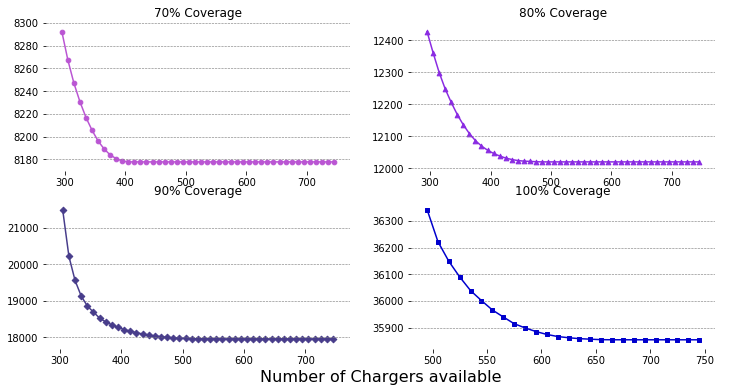

In [416]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# # Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(objval_70.keys(), objval_70.values(), color='mediumorchid')
ax1.scatter(objval_70.keys(), objval_70.values(),color='mediumorchid', s=22)
ax1.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')
ax1.spines['left'].set_color('none')
ax1.spines['right'].set_color('none')

ax2.plot(objval_80.keys(), objval_80.values(),color='blueviolet')
ax2.scatter(objval_80.keys(), objval_80.values(),color='blueviolet', marker = '^', s=22)
ax2.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax3.plot(objval_90.keys(), objval_90.values(),color='darkslateblue')
ax3.scatter(objval_90.keys(), objval_90.values(),color='darkslateblue', marker = 'D', s=22)
ax3.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax3.spines['top'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['right'].set_color('none')

ax4.plot(objval_100.keys(), objval_100.values(),color='mediumblue')
ax4.scatter(objval_100.keys(), objval_100.values(),color='mediumblue', marker = 's', s=22)
ax4.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax4.spines['top'].set_color('none')
ax4.spines['bottom'].set_color('none')
ax4.spines['left'].set_color('none')
ax4.spines['right'].set_color('none')

# # Set common labels
ax.set_xlabel('Number of Chargers available', fontsize = 16)
# ax.set_ylabel('Objective Value', fontsize = 18)

ax1.set_title('70% Coverage', fontsize = 12)
ax2.set_title('80% Coverage', fontsize = 12)
ax3.set_title('90% Coverage', fontsize = 12)
ax4.set_title('100% Coverage', fontsize = 12)
plt.savefig('obval_graphed_4param_B.svg')
plt.show()

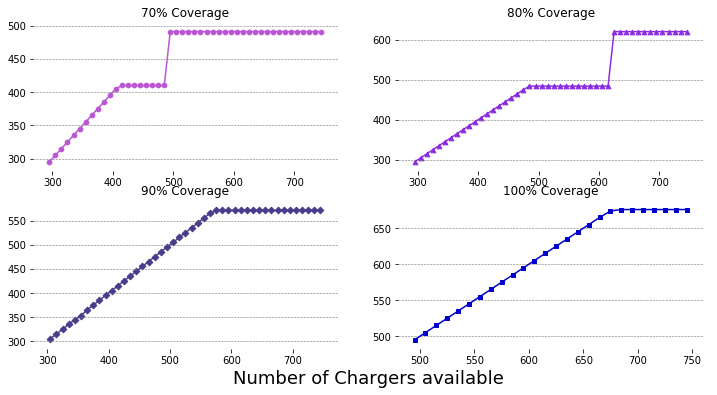

In [417]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(chargers_70.keys(), chargers_70.values(), color='mediumorchid')
ax1.scatter(chargers_70.keys(), chargers_70.values(),color='mediumorchid', s=22)
ax1.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')
ax1.spines['left'].set_color('none')
ax1.spines['right'].set_color('none')

ax2.plot(chargers_80.keys(), chargers_80.values(),color='blueviolet')
ax2.scatter(chargers_80.keys(), chargers_80.values(),color='blueviolet', marker = '^', s=22)
ax2.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax3.plot(chargers_90.keys(), chargers_90.values(),color='darkslateblue')
ax3.scatter(chargers_90.keys(), chargers_90.values(),color='darkslateblue', marker = 'D', s=22)
ax3.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax3.spines['top'].set_color('none')
ax3.spines['bottom'].set_color('none')
ax3.spines['left'].set_color('none')
ax3.spines['right'].set_color('none')

ax4.plot(chargers_100.keys(), chargers_100.values(),color='mediumblue')
ax4.scatter(chargers_100.keys(), chargers_100.values(),color='mediumblue', marker = 's', s=22)
ax4.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
ax4.spines['top'].set_color('none')
ax4.spines['bottom'].set_color('none')
ax4.spines['left'].set_color('none')
ax4.spines['right'].set_color('none')

# Set common labels
ax.set_xlabel('Number of Chargers available', fontsize = 18)
#ax.set_ylabel('Number of Chargers installed', fontsize = 12)

ax1.set_title('70% Coverage', fontsize = 12)
ax2.set_title('80% Coverage', fontsize = 12)
ax3.set_title('90% Coverage', fontsize = 12)
ax4.set_title('100% Coverage', fontsize = 12)
plt.savefig('chargers_installed_graphed.svg')
plt.show()

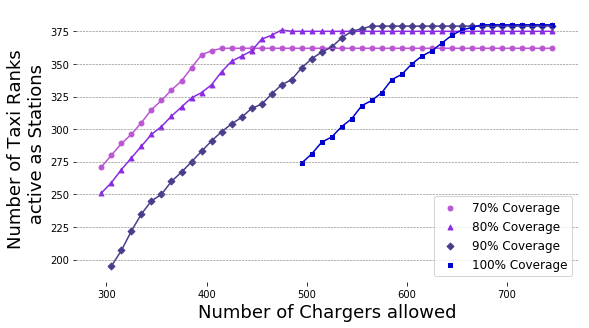

In [427]:
fig, ax1 = plt.subplots(figsize=(9,5))

a = ax1.plot(stations_70.keys(), stations_70.values(), color='mediumorchid')
ax1.scatter(stations_70.keys(), stations_70.values(),color='mediumorchid', s=24, label = '70% Coverage')
ax1.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)

b = ax1.plot(stations_80.keys(), stations_80.values(),color='blueviolet')
ax1.scatter(stations_80.keys(), stations_80.values(),color='blueviolet', marker = '^', s=24, label = '80% Coverage')
ax1.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)

c = ax1.plot(stations_90.keys(), stations_90.values(),color='darkslateblue')
ax1.scatter(stations_90.keys(), stations_90.values(),color='darkslateblue', marker = 'D', s=24, label = '90% Coverage')
ax1.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)

d = ax1.plot(stations_100.keys(), stations_100.values(),color='mediumblue')
ax1.scatter(stations_100.keys(), stations_100.values(),color='mediumblue', marker = 's', s=24, label = '100% Coverage')
ax1.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)

ax1.set_ylabel('Number of Taxi Ranks \n active as Stations', fontsize = 18)
ax1.set_xlabel('Number of Chargers allowed', fontsize = 18)
# plt.title('Actual Station Installation with increasing Chargers allowed', fontsize = 14)
plt.box(on=None)
plt.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
plt.legend(loc = 'lower right', fontsize = 12)
plt.savefig('stations_installed_graphed.svg')
plt.show()

## Find Minimum and re-run model, get output and map

In [194]:
min_objval_100 = min(objval_100.values())
objval_max_charger_100 = min(objval_100, key = objval_100.get)
print('The 100 minimum objective value is {}, with maximum chargers allowed being {}.' .format(min_objval_100, objval_max_charger_100))

The 100 minimum objective value is 35854.062952625085, with maximum chargers allowed being 675.


In [694]:
chargers_100[675]

674.0

In [695]:
stations_100[675]

379

In [195]:
stations_100[675]

380

### Code with final parameters

#### 100% Coverage

In [196]:
final_model_100 = Model('FCLP_final_100')
    
#VARIABLE ASSIGNMENT
#init of x_j and num_j
x_final_100 = {}
num_final_100 = {}
for j in J:
    x_final_100[j] = final_model_100.addVar(vtype = GRB.BINARY, name = 'x_final_100[%s]'%j)
    num_final_100[j] = final_model_100.addVar(vtype = GRB.INTEGER, lb = 0, name = 'num_final_100[%s]'%j)

#Init of y_(i,j)
y_final_100 = {}
for i in I:
    for j in J:
        y_final_100[i,j] = final_model_100.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name="y_final_100[%s,%s]"%(i,j))

#CONSTRAINT ASSIGNMENT
C = 50 #kW
MAX_DIST = 12 #km
MAX_TOTAL = 675
MAX_CHARGERS = 4
M = 200

#i) Meeting all demand: sumj_J (y_ij) = 1 forall i
for i in I:
    final_model_100.addConstr(sum(y_final_100[i,j] for j in J) <= 1, 'Demand_met_up[%s]'%i)

final_model_100.addConstr(quicksum(y_final_100[i,j] for j in J for i in I) >= 1*len(I))

#b) demand only assigned to open facilities: y_ij - x_j <= 0 forall i,j
for i in I:
    for j in J:
        final_model_100.addConstr(y_final_100[i,j] - x_final_100[j] <= 0, 'Strong_limit[%i]'%i)

#c) Max Chargers per candidate location: num_j <= max forall j   IS THIS EVEN NEEDED???
for j in J:
    final_model_100.addConstr(num_final_100[j] <= MAX_CHARGERS*x_final_100[j], 'chargers_station[%s]'%j)

#d) Max total number of chargers: sumj_J (num_j) <= MAX_TOTAL      
final_model_100.addConstr(quicksum(num_final_100[j] for j in J) <= MAX_TOTAL, 'total_chargers') 

#e) Max capacity assigned to a station constraint: ∑_(i∈I) h_i . y_ij ≤ C∙num_j-M(1-x_j)
for j in J:
    final_model_100.addConstr(quicksum(h[i]*y_final_100[i,j] for i in I) <= (C*num_final_100[j]), 'Capacity_constraint[%s]'%j)

#f) distance constraint:
for i in I:
    for j in J:
        if d[i,j] > MAX_DIST:
            final_model_100.addConstr(y_final_100[i,j] == 0)

#SPECIFYING THE OBJECTIVE FUNCTION
final_model_100.setObjective(quicksum(h[i]*d[i,j]*y_final_100[i,j] for i in I for j in J), GRB.MINIMIZE)

final_model_100.reset()
final_model_100.setParam('TimeLimit', 10*60)
final_model_100.optimize()

try:
    objval_final_100 = final_model_100.ObjVal
    chargers_final_100 = sum(num_final_100[j].x for j in J)
    stations_final_100 = sum(1 for j in J if num_final_100[j].x != 0) 
except AttributeError:
    print('Model Infeasible')

Changed value of parameter TimeLimit to 600.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 6.67s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.122000e+03   0.000000e+00     14s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00     14s
       1     

In [197]:
stations_final_100

380

In [198]:
objval_final_100

35854.062952625085

In [199]:
chargers_final_100

674.0

In [201]:
taxi_stands['number_of_chargers_100'] = [num_final_100[j].x for j in taxi_stands.stand_number]

In [202]:
sum(taxi_stands.number_of_chargers)

674.0

In [203]:
taxi_stands.head()

,Borough,Location,Spaces,Times of Operation,Rank No.,Notes,Longitude,Latitude,stand_number,candidate_lat_long,number_of_chargers,geometry,number_of_chargers_100
0,Barking and Dagenham,Rainham Road South (Dagenham East Station),1,24 hours,5657.0,NaN,0.165839,51.544181,1,"(51.544180700000005, 0.16583879999999998)",4.0,POINT (0.1658388 51.54418070000001),4.0
1,Barking and Dagenham,Station Parade/Wakering Road (Barking Station),17,24 hours,5722.0,NaN,0.081832,51.539692,2,"(51.539691999999995, 0.0818324)",4.0,POINT (0.0818324 51.539692),4.0
2,Barnet,Allum Way (Totteridge and Whetstone Station),2,Friday and Saturday 22:00 – 06:00,5833.0,NaN,-0.179150,51.630235,3,"(51.6302347, -0.17915029999999998)",2.0,POINT (-0.1791503 51.6302347),2.0
3,Barnet,Barnet General Hospital,3,24 hours,6030.0,Private land,-0.214486,51.650633,4,"(51.650633299999996, -0.21448649999999997)",3.0,POINT (-0.2144865 51.6506333),3.0
4,Barnet,Brent Cross Station Car Park (Brent Cross Stat...,2,Friday and Saturday 22:00 – 06:00,5851.0,NaN,-0.213075,51.576688,5,"(51.5766881, -0.21307529999999997)",4.0,POINT (-0.2130753 51.5766881),4.0


In [349]:
distance_cov100 = []
for i in I:
    for j in J:
        if y_final_100[i,j].x != 0.0:
            distance_cov100.append(d[i,j])

In [351]:
distance_cov70 = []
for i in I:
    for j in J:
        if y_final_70[i,j].x != 0.0:
            distance_cov70.append(d[i,j])

In [353]:
sum(distance_cov100)/len(distance_cov100)

1.9063689414306864

In [352]:
sum(distance_cov70)/len(distance_cov70)

1.5014729907985662

#### 70% Coverage

In [204]:
final_model_70 = Model('FCLP_final_70')
    
#VARIABLE ASSIGNMENT
#init of x_j and num_j
x_final_70 = {}
num_final_70 = {}
for j in J:
    x_final_70[j] = final_model_70.addVar(vtype = GRB.BINARY, name = 'x_final_70[%s]'%j)
    num_final_70[j] = final_model_70.addVar(vtype = GRB.INTEGER, lb = 0, name = 'num_final_70[%s]'%j)

#Init of y_(i,j)
y_final_70 = {}
for i in I:
    for j in J:
        y_final_70[i,j] = final_model_70.addVar(vtype = GRB.CONTINUOUS, lb=0, ub=1, name="y_final_70[%s,%s]"%(i,j))

#CONSTRAINT ASSIGNMENT
C = 50 #kW
MAX_DIST = 12 #km
MAX_TOTAL = 415
MAX_CHARGERS = 4
M = 200

#i) Meeting all demand: sumj_J (y_ij) = 1 forall i
for i in I:
    final_model_70.addConstr(sum(y_final_70[i,j] for j in J) <= 1, 'Demand_met_up[%s]'%i)

final_model_70.addConstr(quicksum(y_final_70[i,j] for j in J for i in I) >= 0.7*len(I))

#b) demand only assigned to open facilities: y_ij - x_j <= 0 forall i,j
for i in I:
    for j in J:
        final_model_70.addConstr(y_final_70[i,j] - x_final_70[j] <= 0, 'Strong_limit[%i]'%i)

#c) Max Chargers per candidate location: num_j <= max forall j   IS THIS EVEN NEEDED???
for j in J:
    final_model_70.addConstr(num_final_70[j] <= MAX_CHARGERS*x_final_70[j], 'chargers_station[%s]'%j)

#d) Max total number of chargers: sumj_J (num_j) <= MAX_TOTAL      
final_model_70.addConstr(quicksum(num_final_70[j] for j in J) <= MAX_TOTAL, 'total_chargers') 

#e) Max capacity assigned to a station constraint: ∑_(i∈I) h_i . y_ij ≤ C∙num_j-M(1-x_j)
for j in J:
    final_model_70.addConstr(quicksum(h[i]*y_final_70[i,j] for i in I) <= (C*num_final_70[j]), 'Capacity_constraint[%s]'%j)

#f) distance constraint:
for i in I:
    for j in J:
        if d[i,j] > MAX_DIST:
            final_model_70.addConstr(y_final_70[i,j] == 0)

#SPECIFYING THE OBJECTIVE FUNCTION
final_model_70.setObjective(quicksum(h[i]*d[i,j]*y_final_70[i,j] for i in I for j in J), GRB.MINIMIZE)

final_model_70.reset()
final_model_70.setParam('TimeLimit', 10*60)
final_model_70.optimize()

try:
    objval_final_70 = final_model_70.ObjVal
    chargers_final_70 = sum(num_final_70[j].x for j in J)
    stations_final_70 = sum(1 for j in J if num_final_70[j].x != 0) 
except AttributeError:
    print('Model Infeasible')

Changed value of parameter TimeLimit to 600.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4833699 rows, 2828448 columns and 16139055 nonzeros
Variable types: 2827344 continuous, 1104 integer (552 binary)
Coefficient statistics:
  Matrix range     [4e-04, 5e+01]
  Objective range  [3e-04, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 4828023 rows and 2000679 columns (presolve time = 5s) ...
Presolve removed 4828023 rows and 2000679 columns
Presolve time: 7.09s
Presolved: 5676 rows, 827769 columns, 2482755 nonzeros
Variable types: 827217 continuous, 552 integer (0 binary)
Found heuristic solution: objective 24735.343244

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.585400e+03   0.000000e+00     36s

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     

In [205]:
stations_final_70

362

In [206]:
objval_final_70

8177.892908278947

In [207]:
chargers_final_70

410.0

In [208]:
taxi_stands['number_of_chargers_70'] = [num_final_70[j].x for j in taxi_stands.stand_number]

In [209]:
sum(taxi_stands.number_of_chargers_70)

410.0

In [210]:
taxi_stands.head()

,Borough,Location,Spaces,Times of Operation,Rank No.,Notes,Longitude,Latitude,stand_number,candidate_lat_long,number_of_chargers,geometry,number_of_chargers_100,number_of_chargers_70
0,Barking and Dagenham,Rainham Road South (Dagenham East Station),1,24 hours,5657.0,NaN,0.165839,51.544181,1,"(51.544180700000005, 0.16583879999999998)",4.0,POINT (0.1658388 51.54418070000001),4.0,2.0
1,Barking and Dagenham,Station Parade/Wakering Road (Barking Station),17,24 hours,5722.0,NaN,0.081832,51.539692,2,"(51.539691999999995, 0.0818324)",4.0,POINT (0.0818324 51.539692),4.0,2.0
2,Barnet,Allum Way (Totteridge and Whetstone Station),2,Friday and Saturday 22:00 – 06:00,5833.0,NaN,-0.179150,51.630235,3,"(51.6302347, -0.17915029999999998)",2.0,POINT (-0.1791503 51.6302347),2.0,1.0
3,Barnet,Barnet General Hospital,3,24 hours,6030.0,Private land,-0.214486,51.650633,4,"(51.650633299999996, -0.21448649999999997)",3.0,POINT (-0.2144865 51.6506333),3.0,1.0
4,Barnet,Brent Cross Station Car Park (Brent Cross Stat...,2,Friday and Saturday 22:00 – 06:00,5851.0,NaN,-0.213075,51.576688,5,"(51.5766881, -0.21307529999999997)",4.0,POINT (-0.2130753 51.5766881),4.0,1.0


In [211]:
taxi_stands.to_csv('taxi_stands_with_chargers_0.7cov410chargers_1cov674chargers.csv')

## Create Map

In [212]:
taxi_stand_geometry = [Point(xy) for xy in zip(taxi_stands['Longitude'], taxi_stands['Latitude'])]
crs = {'init' : 'epsg:4326'}
taxi_stands_map = GeoDataFrame(taxi_stands, crs = crs, geometry = taxi_stand_geometry)
taxi_stands_map.head()

,Borough,Location,Spaces,Times of Operation,Rank No.,Notes,Longitude,Latitude,stand_number,candidate_lat_long,number_of_chargers,geometry,number_of_chargers_100,number_of_chargers_70
0,Barking and Dagenham,Rainham Road South (Dagenham East Station),1,24 hours,5657.0,NaN,0.165839,51.544181,1,"(51.544180700000005, 0.16583879999999998)",4.0,POINT (0.1658388 51.54418070000001),4.0,2.0
1,Barking and Dagenham,Station Parade/Wakering Road (Barking Station),17,24 hours,5722.0,NaN,0.081832,51.539692,2,"(51.539691999999995, 0.0818324)",4.0,POINT (0.0818324 51.539692),4.0,2.0
2,Barnet,Allum Way (Totteridge and Whetstone Station),2,Friday and Saturday 22:00 – 06:00,5833.0,NaN,-0.179150,51.630235,3,"(51.6302347, -0.17915029999999998)",2.0,POINT (-0.1791503 51.6302347),2.0,1.0
3,Barnet,Barnet General Hospital,3,24 hours,6030.0,Private land,-0.214486,51.650633,4,"(51.650633299999996, -0.21448649999999997)",3.0,POINT (-0.2144865 51.6506333),3.0,1.0
4,Barnet,Brent Cross Station Car Park (Brent Cross Stat...,2,Friday and Saturday 22:00 – 06:00,5851.0,NaN,-0.213075,51.576688,5,"(51.5766881, -0.21307529999999997)",4.0,POINT (-0.2130753 51.5766881),4.0,1.0


In [213]:
london_boroughs = GeoDataFrame.from_file('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
london_boroughs = london_boroughs.to_crs(epsg=4326)

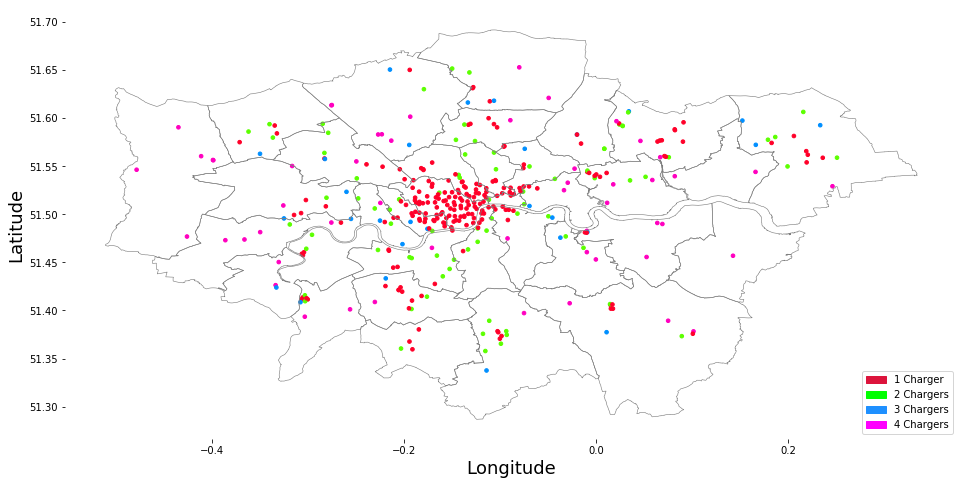

In [430]:
a = mpatches.Patch(color='crimson', label='1 Charger')
b = mpatches.Patch(color='lime', label= '2 Chargers')
c = mpatches.Patch(color='dodgerblue', label= '3 Chargers')
d = mpatches.Patch(color='magenta', label= '4 Chargers')

mpl.rcParams['image.cmap'] = 'gist_rainbow'
fig,ax = plt.subplots(figsize = (16,16))
taxi_stands_map.loc[taxi_stands_map.number_of_chargers_100 > 0].plot(column = 'number_of_chargers_100', \
                                                                ax = ax, markersize = 13, marker= 'o')
london_boroughs.geometry.boundary.plot(color=None, edgecolor='grey', linewidth = 0.6, ax=ax, alpha = 1)
plt.legend(handles=[a, b, c, d], loc="lower right", fontsize =16)
plt.box(on=None)
# plt.title('Charging Stations across London at 100% Coverage', fontsize = 14)
plt.ylabel('Latitude', fontsize = 18)
plt.xlabel('Longitude', fontsize = 18)
plt.legend(handles=[a, b, c, d], loc="lower right")
plt.savefig('Charging Stations Mapped London_100 Coverage.svg')
plt.show()

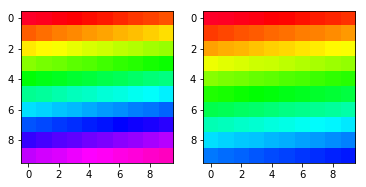

In [436]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_rainbow')
new_cmap = truncate_colormap(cmap, 0.0, 0.75)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

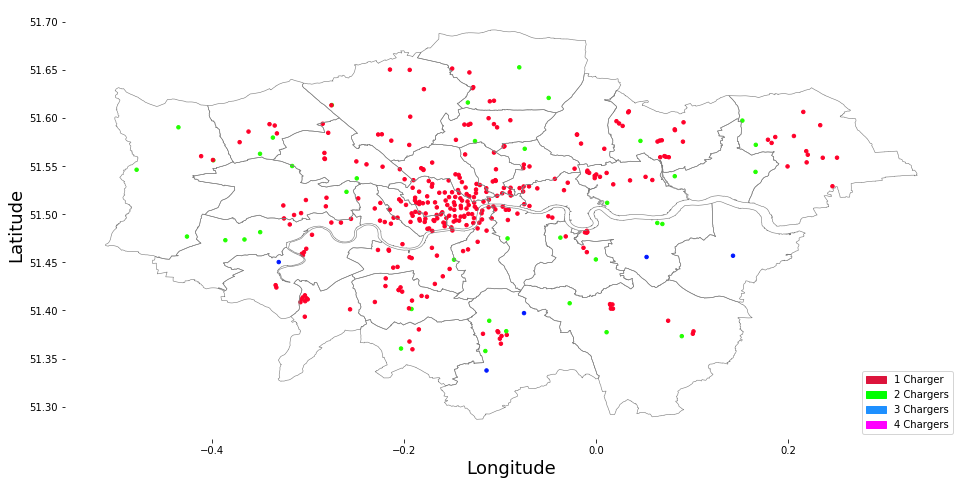

In [441]:
mpl.rcParams['image.cmap'] = 'gist_rainbow'
fig,ax = plt.subplots(figsize = (16,16))
taxi_stands_map.loc[taxi_stands_map.number_of_chargers_70 > 0].plot(column = 'number_of_chargers_70', \
                                                                ax = ax, markersize = 12, marker= 'o', cmap = new_cmap)
london_boroughs.geometry.boundary.plot(color=None, edgecolor='grey', linewidth = 0.6, ax=ax, alpha = 1)
plt.legend(handles=[a, b, c, d], loc="lower right")
plt.box(on=None)
# plt.title('Charging Stations across London at 70% Coverage', fontsize = 14)
plt.ylabel('Latitude', fontsize = 18)
plt.xlabel('Longitude', fontsize = 18)
plt.legend(handles=[a, b, c, d], loc="lower right")
plt.savefig('Charging Stations Mapped London_70 Coverage.svg')
plt.show()

In [243]:
boroughs = list(taxi_stands.Borough.unique())

taxi_ranks_total = []
charging_stations_100 = []
number_of_chargers_100 = []

charging_stations_70 = []
number_of_chargers_70 = []

for borough in boroughs:
    temp = taxi_stands.loc[taxi_stands.Borough == borough]
    taxi_ranks_total.append(len(temp))
    charging_stations_100.append(len(temp.loc[temp.number_of_chargers_100 > 0]))
    number_of_chargers_100.append(int(sum(temp.loc[temp.number_of_chargers_100 > 0].number_of_chargers_100)))
    
    charging_stations_70.append(len(temp.loc[temp.number_of_chargers_70 > 0]))
    number_of_chargers_70.append(int(sum(temp.loc[temp.number_of_chargers > 0].number_of_chargers_70)))

In [244]:
stations_by_borough = pd.DataFrame({'Borough': boroughs, 'Taxi Ranks': taxi_ranks_total,\
                                    'Taxi Ranks with Station_100': charging_stations_100, \
                                    'Total Chargers_100': number_of_chargers_100, \
                                    'Taxi Ranks with Station_70': charging_stations_70, \
                                    'Total Chargers_70': number_of_chargers_70})

In [245]:
stations_by_borough['rank_coverage_100'] = [round(y/x*100) for x,y in zip(stations_by_borough['Taxi Ranks'], stations_by_borough['Taxi Ranks with Station_100'])]
stations_by_borough['rank_coverage_70'] = [round(y/x*100) for x,y in zip(stations_by_borough['Taxi Ranks'], stations_by_borough['Taxi Ranks with Station_70'])]

stations_by_borough

,Borough,Taxi Ranks,Taxi Ranks with Station_100,Total Chargers_100,Taxi Ranks with Station_70,Total Chargers_70,rank_coverage_100,rank_coverage_70
0,Barking and Dagenham,2,2,8,2,4,100,100
1,Barnet,10,10,33,10,11,100,100
2,Bexley,1,1,4,1,3,100,100
3,Brent,11,11,22,11,12,100,100
4,Bromley,12,11,24,11,14,92,92
5,Camden,42,26,29,21,21,62,50
6,Croydon,12,12,23,12,19,100,100
7,Ealing,9,9,18,9,11,100,100
8,Enfield,9,9,21,9,12,100,100
9,Greenwich,8,7,21,7,11,88,88


In [475]:
stations_by_borough.to_csv('stations_by_borough.csv')

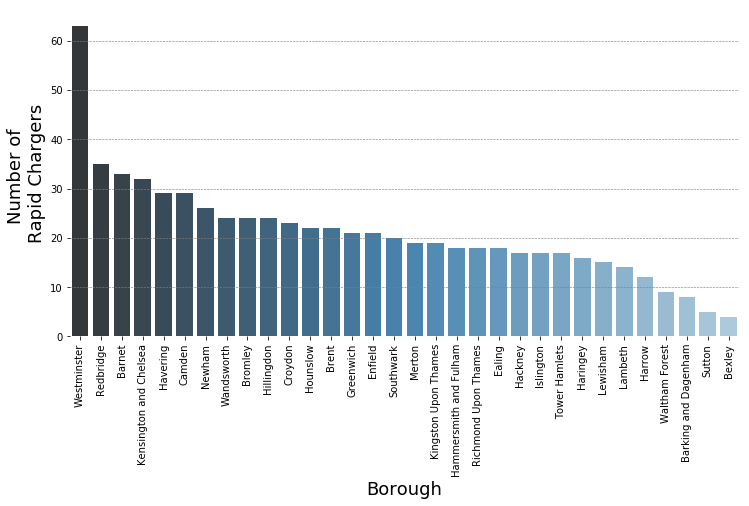

In [474]:
by_borough_sorted = stations_by_borough.sort_values(['Total Chargers_100'], ascending=False).reset_index(drop=True)

plt.subplots(figsize = (12,6))
sns.barplot(x = by_borough_sorted.Borough, y = by_borough_sorted['Total Chargers_100'], palette="Blues_d")
plt.xticks(rotation=90)
plt.ylabel('Number of \nRapid Chargers', fontsize = 18)
plt.xlabel('Borough', fontsize = 18)
# plt.title('Chargers per Borough', fontsize = 18)
plt.box(on=None)
plt.grid(axis = 'y', color='grey', linestyle='--', linewidth=0.6)
plt.savefig('Charger_per_borough.png')
plt.show()

## Assign Points to grid cells

In [219]:
london = GeoDataFrame.from_file('/Users/johannesbreit/OneDrive - Imperial College London/irr/python model/'\
                                'lp-consultation-oct-2009-inner-outer-london-shp/'\
                                'lp-consultation-oct-2009-inner-outer-london.shp')
london = london.to_crs(epsg=4326)
##create a grid of london
ymax = 51.70
ymin = 51.25
xmax = 0.4
xmin = -0.6
#distance between (-0.1, 51.70 and -0.1, 51.25) = 50 km ymax
#distance between (-0.6, 51.5 and 0.4, 51.5) = 69 km xmax
#square grid would require 
xx, yy = np.meshgrid(np.linspace(xmin,xmax,int(69000/500)), np.linspace(ymin,ymax,int(50000/500)))
xc = xx.flatten()
yc = yy.flatten()

points = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
in_map =  np.array([points.within(geom) for geom in london.geometry]).sum(axis=0)
points = GeoSeries([val for pos,val in enumerate(points) if in_map[pos]])

In [224]:
len(points)

6235

In [221]:
taxi_grid = pd.DataFrame(points, columns = ['coordinate'])
taxi_grid['point'] = np.arange(1,len(taxi_grid)+1)
taxi_grid = taxi_grid[['point', 'coordinate']]
taxi_grid['charger_count_100'] = np.zeros(len(taxi_grid))
taxi_grid['charger_count_70'] = np.zeros(len(taxi_grid))
taxi_grid.head()

,point,coordinate,charger_count_100,charger_count_70
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0,0.0
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0,0.0
2,3,POINT (0.06423357664233575 51.29090909090909),0.0,0.0
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0,0.0
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0,0.0


In [222]:
for i in tqdm_notebook(range(len(taxi_stands_map)), desc = 'Loop'):
    distances = pd.DataFrame(columns = ['taxi_point','grid_point', 'distance'])
    for j in range(len(taxi_grid)):
        distance = taxi_stands_map.loc[i, 'geometry'].distance(taxi_grid.loc[j, 'coordinate'])
 
        to_append = pd.DataFrame([[taxi_stands_map.loc[i, 'geometry'], taxi_grid.loc[j, 'coordinate'], distance]], \
                                 columns = ['taxi_point', 'grid_point', 'distance'])
        
        distances = distances.append(to_append, ignore_index=True)

    index_min_distance = distances['distance'].idxmin()
    min_index_finder = (taxi_grid['coordinate'] == distances.loc[index_min_distance, 'grid_point']).reset_index()
    min_index = int(min_index_finder[min_index_finder["coordinate"] == True].index.values)
    taxi_grid.loc[min_index, 'charger_count_100'] += taxi_stands_map.loc[i, 'number_of_chargers_100']
    taxi_grid.loc[min_index, 'charger_count_70'] += taxi_stands_map.loc[i, 'number_of_chargers_70']
   # print(taxi_stands_map.loc[i, 'number_of_chargers'])
#     print(i)
#     print(taxi_grid.loc[min_index,:])

In [732]:
taxi_grid.charger_count.value_counts()

0.0     5904
2.0      100
3.0       81
5.0       59
4.0       57
6.0       11
7.0       10
10.0       3
8.0        3
9.0        2
15.0       1
22.0       1
13.0       1
14.0       1
1.0        1
Name: charger_count, dtype: int64

In [225]:
taxi_grid.charger_count_100.value_counts()

0.0    5905
1.0     147
2.0      91
4.0      54
3.0      34
5.0       2
8.0       1
9.0       1
Name: charger_count_100, dtype: int64

In [226]:
taxi_grid.charger_count_70.value_counts()

0.0    5913
1.0     246
2.0      65
3.0      10
4.0       1
Name: charger_count_70, dtype: int64

In [227]:
taxi_grid.head()

,point,coordinate,charger_count_100,charger_count_70
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0,0.0
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0,0.0
2,3,POINT (0.06423357664233575 51.29090909090909),0.0,0.0
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0,0.0
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0,0.0


In [228]:
charger_GIS_2 = GeoDataFrame(taxi_grid, crs = crs, geometry = points)

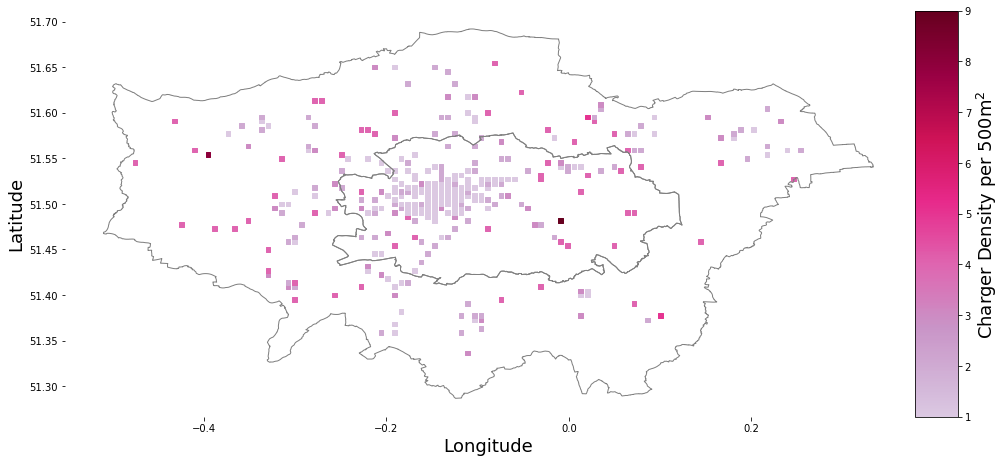

In [460]:
mpl.rcParams['image.cmap'] = 'gist_rainbow'
fig,ax = plt.subplots(figsize = (16,16))
plt.box(on=None)
plt.ylabel('Latitude', fontsize = 18)
plt.xlabel('Longitude', fontsize = 18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
charger_GIS_2.loc[charger_GIS_2.charger_count_100 > 0].plot(column = 'charger_count_100', ax = ax, markersize = 22, alpha = 1, marker = 's',\
                       label = 'test', legend=True, cax = cax, cmap = new_cmap_2)
plt.ylabel('Charger Density per 500m$^2$', fontsize = 18)
london.geometry.boundary.plot(color=None, edgecolor='grey', linewidth = 1, ax=ax, alpha = 1)

plt.savefig('charger_concentration_100.svg')
plt.show()

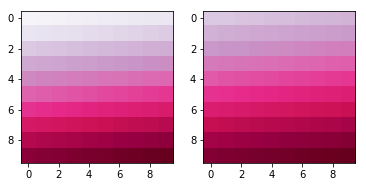

In [462]:
arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap_2 = plt.get_cmap('PuRd')
new_cmap_2 = truncate_colormap(cmap_2, 0.2, 1.0)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap_2)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap_2)
plt.show()

new_cmap_3 = truncate_colormap(cmap_2, 0.2, 0.525)

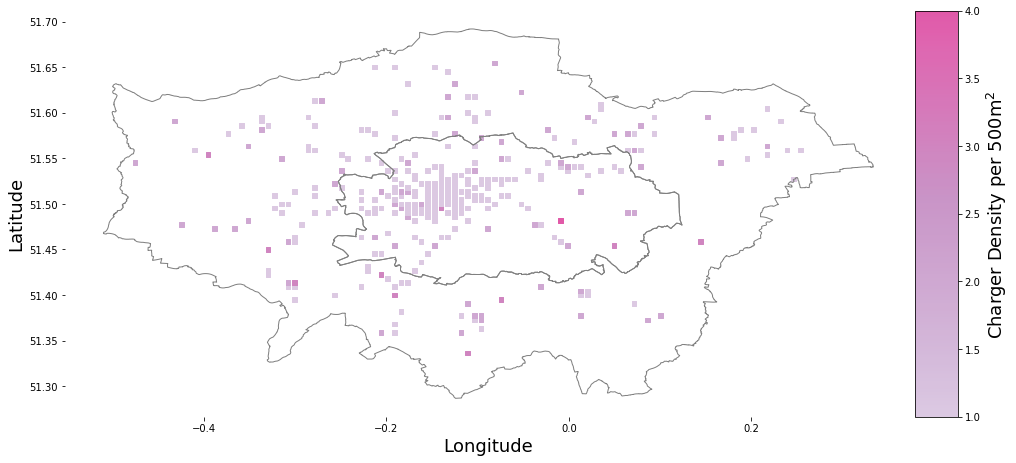

In [464]:
mpl.rcParams['image.cmap'] = 'PuRd'
fig,ax = plt.subplots(figsize = (16,16))
plt.box(on=None)
plt.ylabel('Latitude', fontsize = 18)
plt.xlabel('Longitude', fontsize = 18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
charger_GIS_2.loc[charger_GIS_2.charger_count_70 > 0].plot(column = 'charger_count_70', ax = ax, markersize = 22, alpha = 1, marker = 's',\
                       label = 'test', legend=True, cax = cax, cmap = new_cmap_3)
plt.ylabel('Charger Density per 500m$^2$', fontsize = 18)
london.geometry.boundary.plot(color=None, edgecolor='grey', linewidth = 1, ax=ax, alpha = 1)

plt.savefig('charger_concentration_70.svg')
plt.show()

In [394]:
charger_GIS_2.to_csv('clustered_chargers_per_500m-squared_param_vary.csv')

In [395]:
charger_GIS_2.head()

,point,coordinate,charger_count_100,charger_count_70,geometry,binned_charger_count_100
0,1,POINT (-0.1255474452554745 51.29090909090909),0.0,0.0,POINT (-0.1255474452554745 51.29090909090909),0
1,2,POINT (-0.1182481751824818 51.29090909090909),0.0,0.0,POINT (-0.1182481751824818 51.29090909090909),0
2,3,POINT (0.06423357664233575 51.29090909090909),0.0,0.0,POINT (0.06423357664233575 51.29090909090909),0
3,4,POINT (-0.1255474452554745 51.29545454545455),0.0,0.0,POINT (-0.1255474452554745 51.29545454545455),0
4,5,POINT (-0.1182481751824818 51.29545454545455),0.0,0.0,POINT (-0.1182481751824818 51.29545454545455),0
